In [21]:
import numpy as np; import matplotlib.pyplot as plt
# 物理定数：万有引力定数 (m^3 kg^-1 s^-2), 地球の質量 (kg), 月の質量 (kg), 月の半径 (m)
G = 6.67430e-11; M_e = 5.972e24; M_m = 7.342e22; R_m = 1.737e6  # 物理定数定義
# ケプラー方程式（M = E - e*sin(E)）をニュートン法で解くことで離心近点角Eを計算する
def kepler_E(M, e, tol=1e-12, itmax=50):  #  M=平均近点角, e=離心率
    M = (M + np.pi) % (2*np.pi) - np.pi; E = M if e < 0.8 else np.pi  # M正規化、E初期化
    for _ in range(itmax):  # ニュートン法（はニュートン・ラフソン法）の最大ゝ(itmax回)
        f = E - e*np.sin(E) - M; fp = 1 - e*np.cos(E); dE = -f/fp; E += dE  # ニュートン法
        if abs(dE) < tol:  # 収束判定
            break
    return E  # 偏心近点角Eを返す
# 離心近点角Eから真近点角fと軌道半径rを計算する, r=楕円軌道の距離,  f=真近点角（軌道上の角度位置）
def true_anomaly_and_radius(E, a, e):  # 真近点角と軌道半径を計算
    cosE, sinE = np.cos(E), np.sin(E); r = a*(1 - e*cosE); t = np.tan(E/2.0)       # rとtan(E/2)計算
    factor = np.sqrt((1+e)/(1-e)); f = 2*np.arctan2(factor*t, 1.0) % (2*np.pi)  # 真近点角f計算
    return f, r  # f(真近点角)とr(楕円軌道の距離)を返す
# 月の自転運動（θ, ω）を潮汐トルクと表裏差トルクを適用しながら4次ルンゲクッタで数値積分。
# omega0:初期自転角速度, theta0:初期自転角度,  t_total_factor: 計算時間（軌道周期の倍数）
def integrate_spin(omega0, theta0,a,e,BA=0.,k2=0.03,dtau=1e4,t_total_factor=200.0,dt_factor=2000):  
    n = np.sqrt(G*(M_e + M_m) / a**3)  # 平均運動nを計算      dt_factor: 時間刻み（軌道周期の分割数）↑
    T_orb = 2*np.pi / n; dt = T_orb / dt_factor; N = int(np.ceil((t_total_factor * T_orb) / dt))  # 時間設定
    theta = theta0; omega = omega0; M_mean = 0.0; Mdot = n; ts = np.empty(N)  # 初期化
    omegas = np.empty(N); f_dots = np.empty(N); psis = np.empty(N)  # 結果配列初期化
    for i in range(N):  # 時間ステップごとに必要なパラーメータを計算していく
        t = i*dt; M_now = (M_mean + Mdot*dt) if i>0 else M_mean  # 時刻と平均近点角M,を計算
        E = kepler_E(M_now, e); f, r = true_anomaly_and_radius(E, a, e) # 離心近点角E,真近点角f,軌道半径r計算
        f_dot = np.sqrt(G*(M_e + M_m)*a*(1-e**2)) / (r**2)      # 軌道角速度f_dotを計算
        def rhs(theta, omega):  # 微分方程式の右辺関数（微分方程式：dθ/dt = ω, dω/dt = (Np+Nt)/I）
            Np = -1.5 * (G*M_e) / (r**3) * BA * np.sin(2.0*(theta - f)) if BA != 0.0 else 0.0# 表裏違いによる力(トルク)
            Nt = -3.0 * k2 * (G*(M_e**2)) * (R_m**5) * dtau * (omega - f_dot) / (r**6)# 潮汐変形による力(（)トルク)
            domega = (Np + Nt) / (0.393 * M_m * R_m**2); dtheta = omega  # 角加速度とdθ/dt
            return dtheta, domega  # 微分値を返す
        k1t, k1w = rhs(theta, omega)                                         # 4次のルンゲクッタのk1計算
        k2t, k2w = rhs(theta + 0.5*dt*k1t, omega + 0.5*dt*k1w)  # 4次のルンゲクッタのk2計算
        k3t, k3w = rhs(theta + 0.5*dt*k2t, omega + 0.5*dt*k2w)  # 4次のルンゲクッタのk3計算
        k4t, k4w = rhs(theta + dt*k3t, omega + dt*k3w)              # 4次のルンゲクッタのk4計算
        theta += (dt/6.0)*(k1t + 2*k2t + 2*k3t + k4t)                  # 月の回転角度θを計算
        omega += (dt/6.0)*(k1w + 2*k2w + 2*k3w + k4w)           # 角加速度の積分ωを計算
        M_mean = M_now; ts[i] = t; omegas[i] = omega; f_dots[i] = f_dot #平均近点角,時刻,自転角速度,軌道角速度計算
        psis[i] = (theta - f + np.pi) % (2*np.pi) - np.pi                  # 自転と軌道の位相差（ψ=θ-f）を計算
    return ts, omegas, f_dots, psis
# シミュレーション関数: a=地球-月間の平均距離(m),e=楕円軌道の離心率
# k2=潮汐変形のラブ数,dtau=潮汐変形の遅延時間, t_total_factor=シミュレーション時間（軌道周期の倍数）
def simulation(e=0.055, omega_init=1.1, moment_rate=50, k2=0.024, dtau=500,t_total_factor=1000):
    a = 3.844e8; n = np.sqrt(G*(M_e + M_m) / a**3); T_orb = 2*np.pi / n  # 軌道パラメータ
    omega0 = omega_init * n; theta0 = 0.0; C = 0.393 * M_m * R_m**2    # 初期条件
    moment = 2.3e-4 * C * moment_rate  # 表側と裏側の重さ違いによる慣性モーメント差
    ts, omegas, f_dots, psis = integrate_spin(omega0, theta0, a, e, BA=moment, k2=k2, dtau=dtau, 
                                              t_total_factor=t_total_factor, dt_factor=2000)  # 自転を数値積分していく
    return (ts, omegas, f_dots, psis, n)  # 結果を返す
# 結果をプロットする関数
def plot_results(results):  
    for result in results:    # 複数条件計算対応（本記事では複数条件は使っていません）
        plt.plot(result['ts']/86400.0, result['omegas']/result['n'],label=result['label'],linewidth=10,alpha=0.2) 
    plt.xlabel('時間 [日]'); plt.ylabel('正規化速度（角速度） (ω/n)')  # 軸ラベル設定
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.ylim(0.8, 1.2); plt.show()  # 凡例、グリッド、表示

/var/folders/mn/nmxx09wj21j7f81mwghvt1sw0000gn/T/ipykernel_15572/4193490467.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(); plt.grid(True); plt.tight_layout(); plt.ylim(0.8, 1.2); plt.show()  # 凡例、グリッド、表示


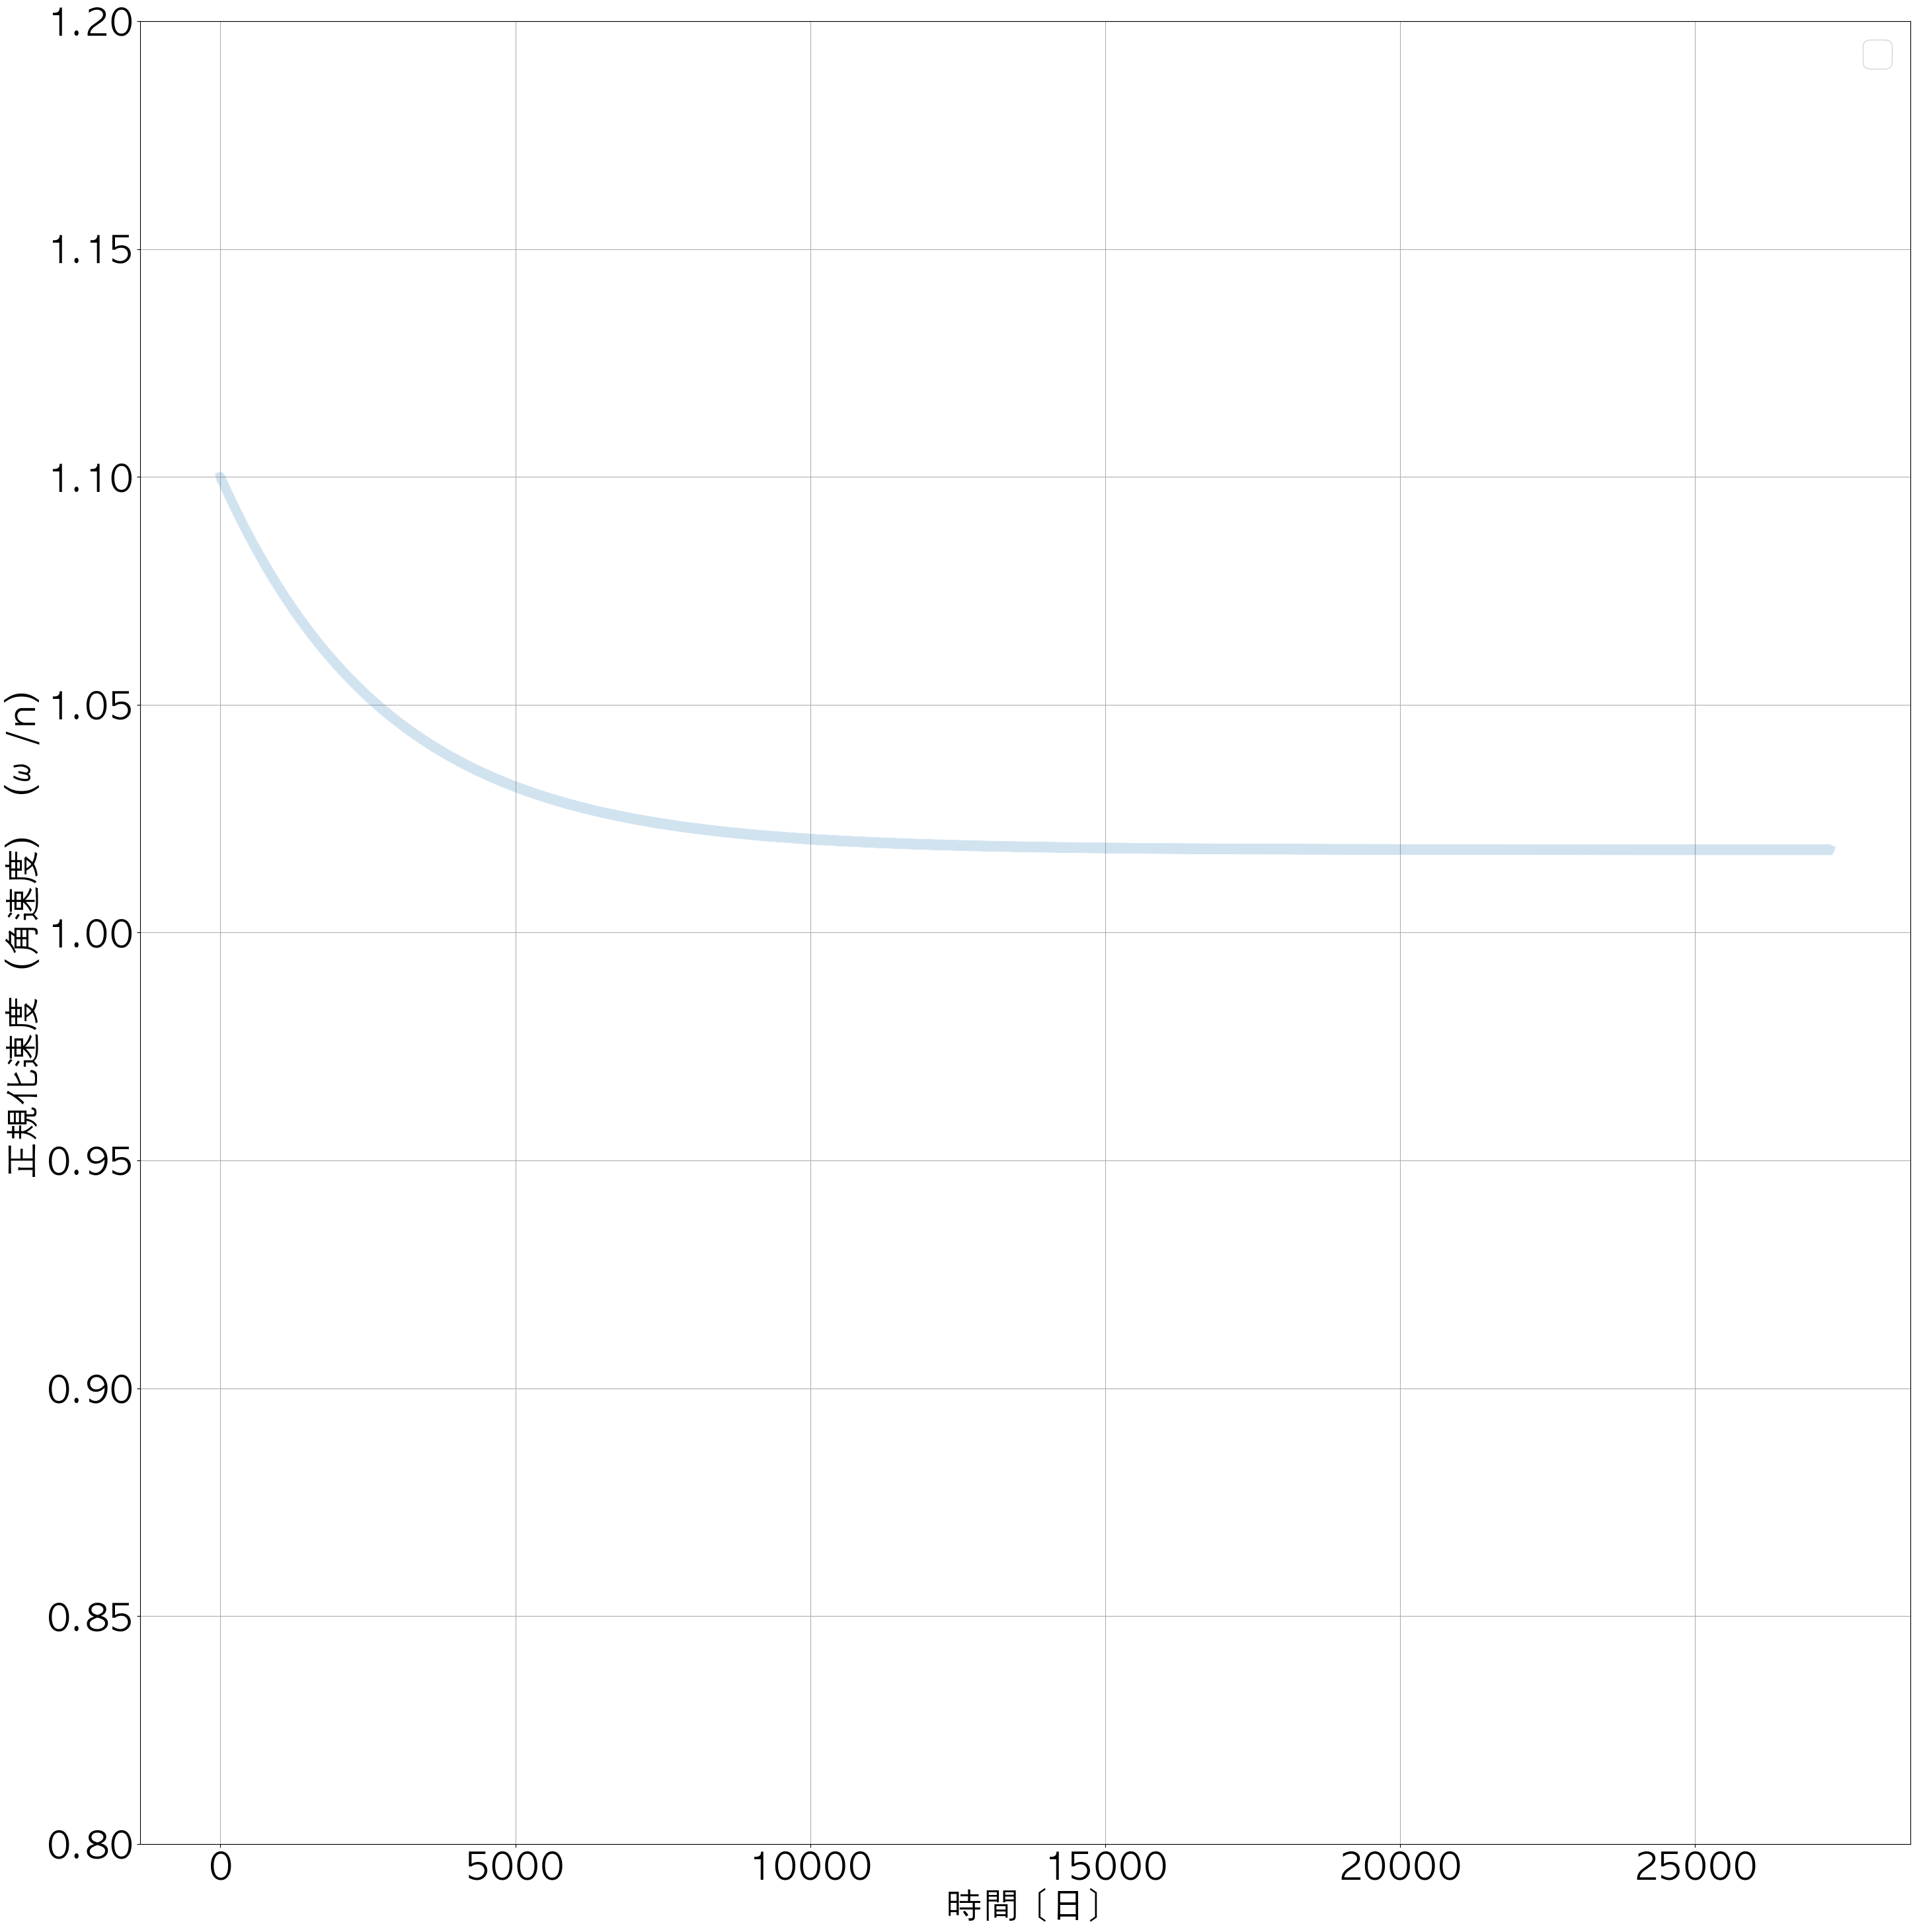

In [25]:
# 楕円軌道で表裏側の重さが同じ場合
ts, omegas, f_dots, psis, n = simulation(e=0.055,omega_init =1.1,
    moment_rate=0,k2=1.0, dtau=1.0e7,t_total_factor=1000); results = []
results.append( {"ts":ts, 'omegas':omegas, 'f_dots':f_dots, 'psis':psis, "n":n, 'label': ''} ); plot_results(results)

/var/folders/mn/nmxx09wj21j7f81mwghvt1sw0000gn/T/ipykernel_15572/4193490467.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(); plt.grid(True); plt.tight_layout(); plt.ylim(0.8, 1.2); plt.show()  # 凡例、グリッド、表示


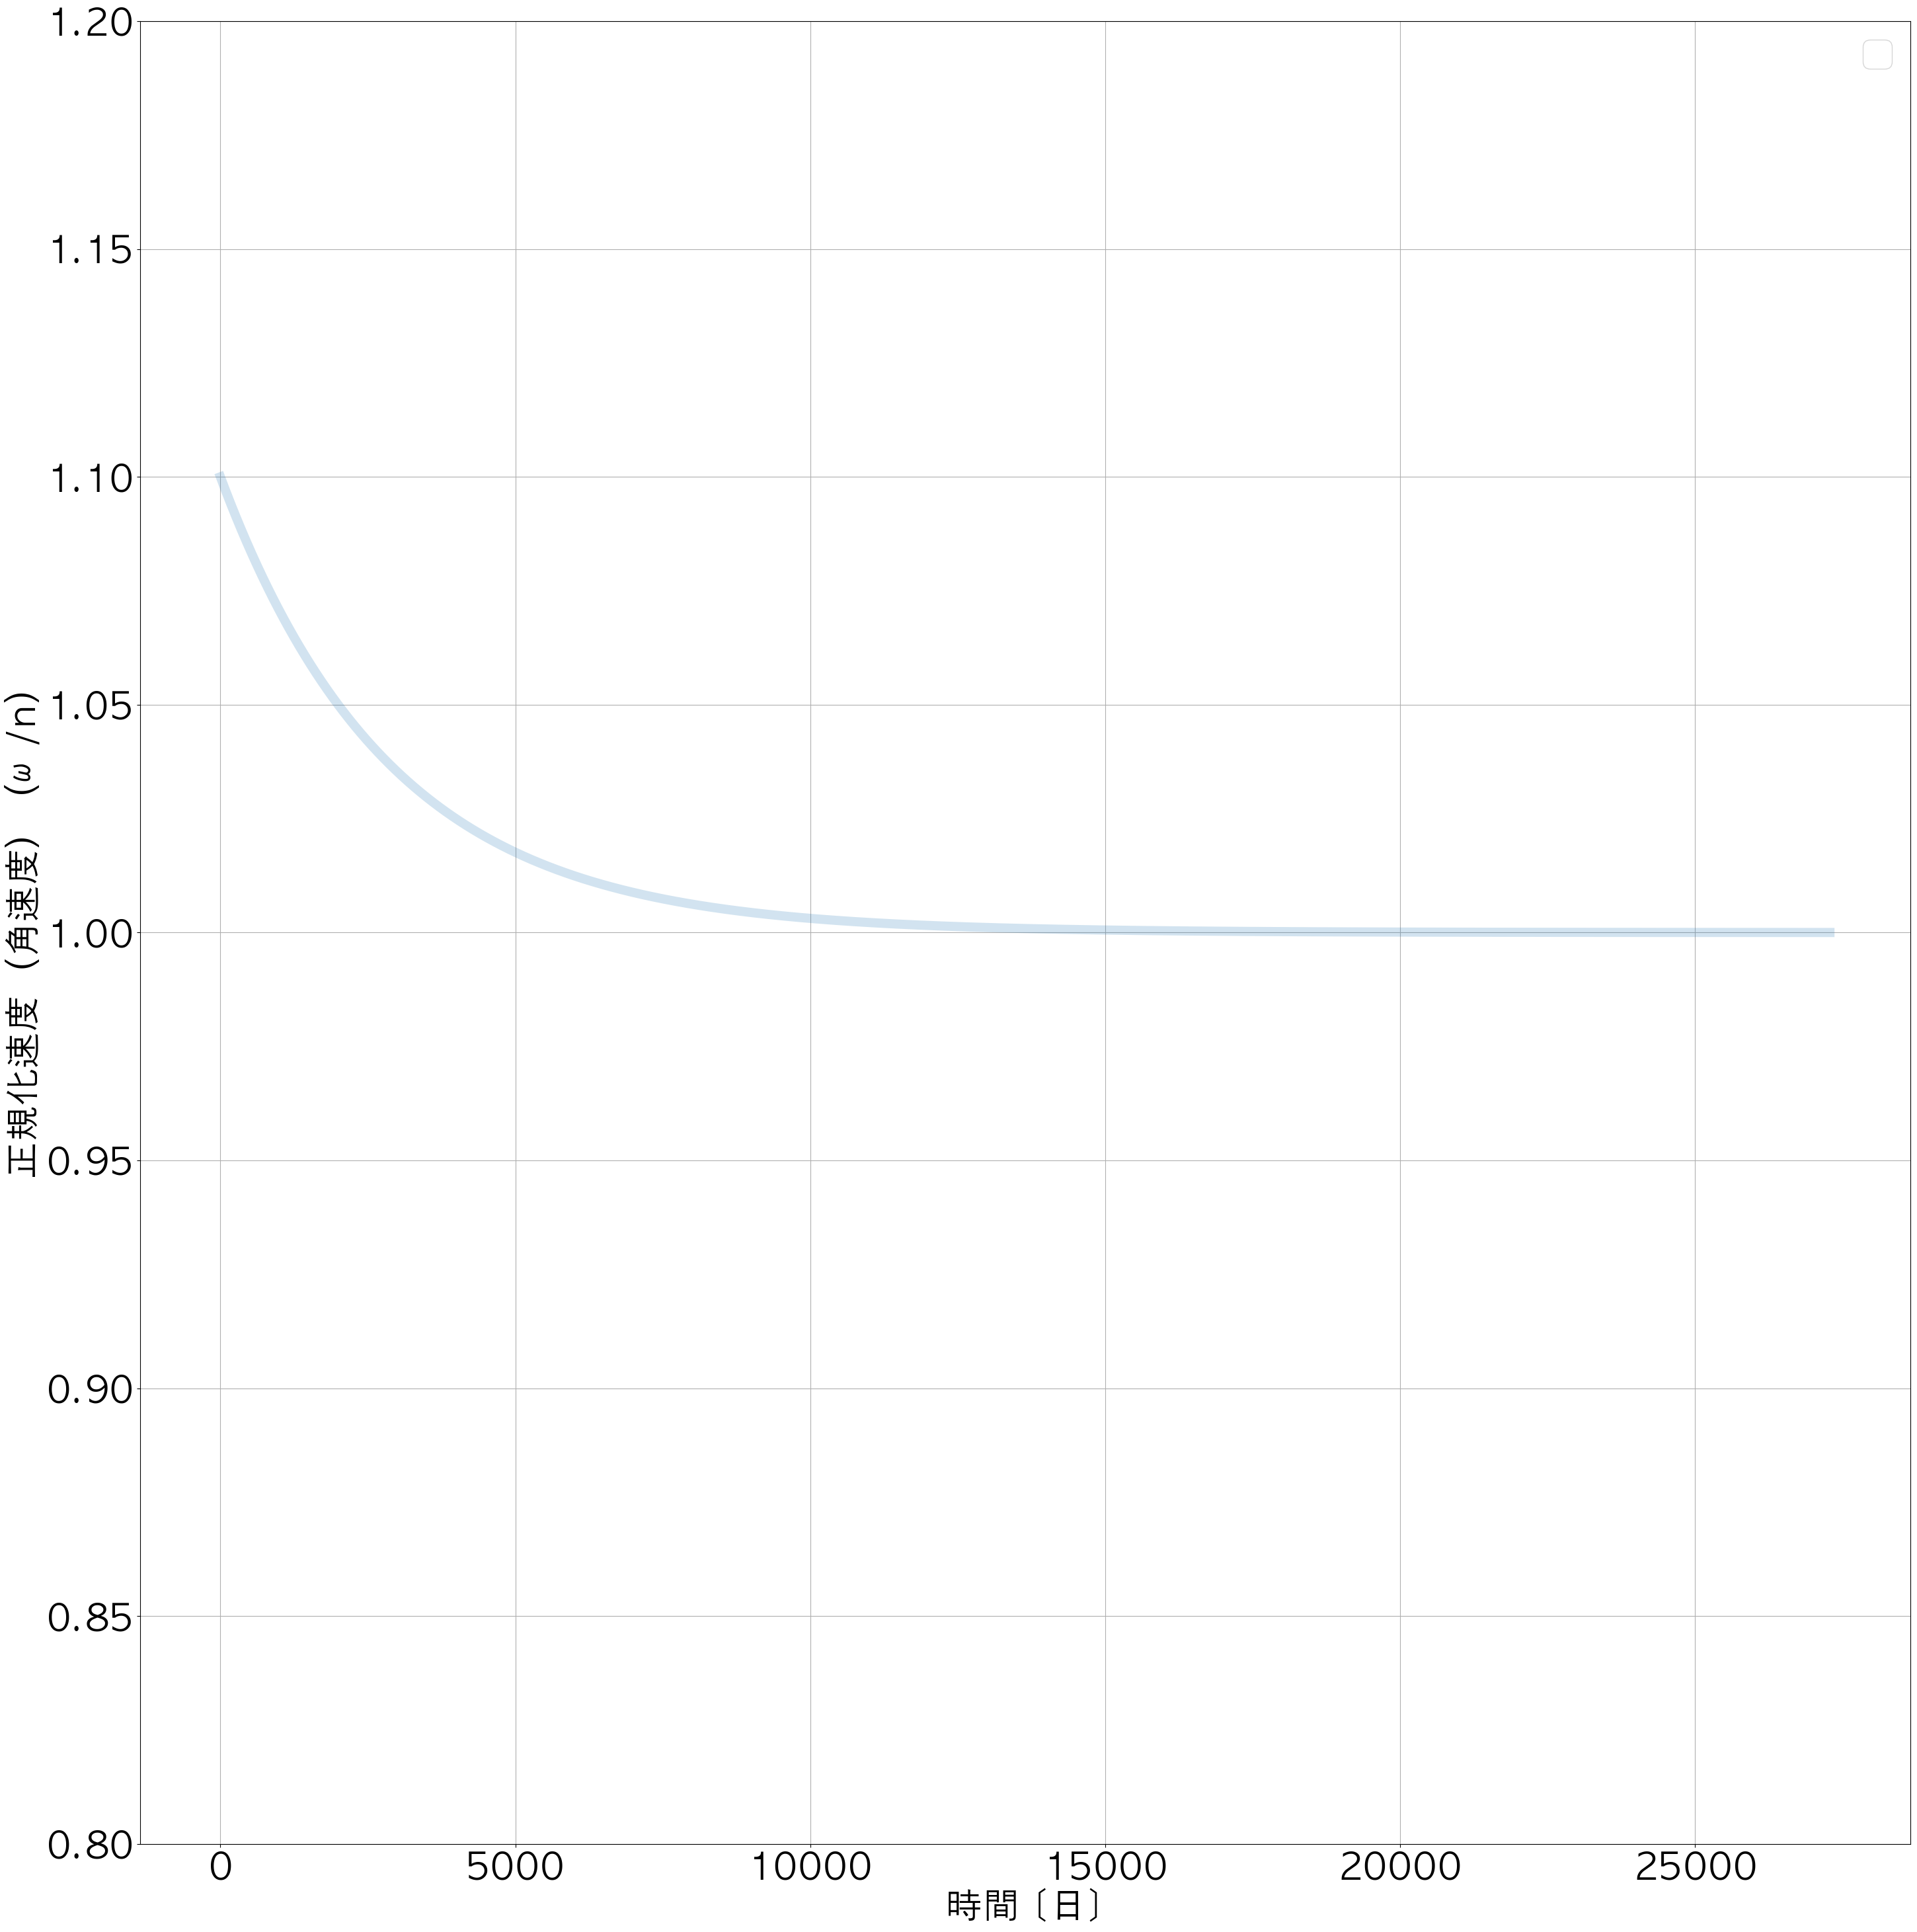

In [26]:
# 円軌道で表裏側の重さが同じ場合
ts, omegas, f_dots, psis, n = simulation(e=0.0, omega_init=1.1,
    moment_rate=0, k2=1.0, dtau=1.0e7, t_total_factor=1000); results = []
results.append( {"ts":ts, 'omegas':omegas, 'f_dots':f_dots, 'psis':psis, "n":n, 'label': ''} ); plot_results(results)

/var/folders/mn/nmxx09wj21j7f81mwghvt1sw0000gn/T/ipykernel_15572/4193490467.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(); plt.grid(True); plt.tight_layout(); plt.ylim(0.8, 1.2); plt.show()  # 凡例、グリッド、表示


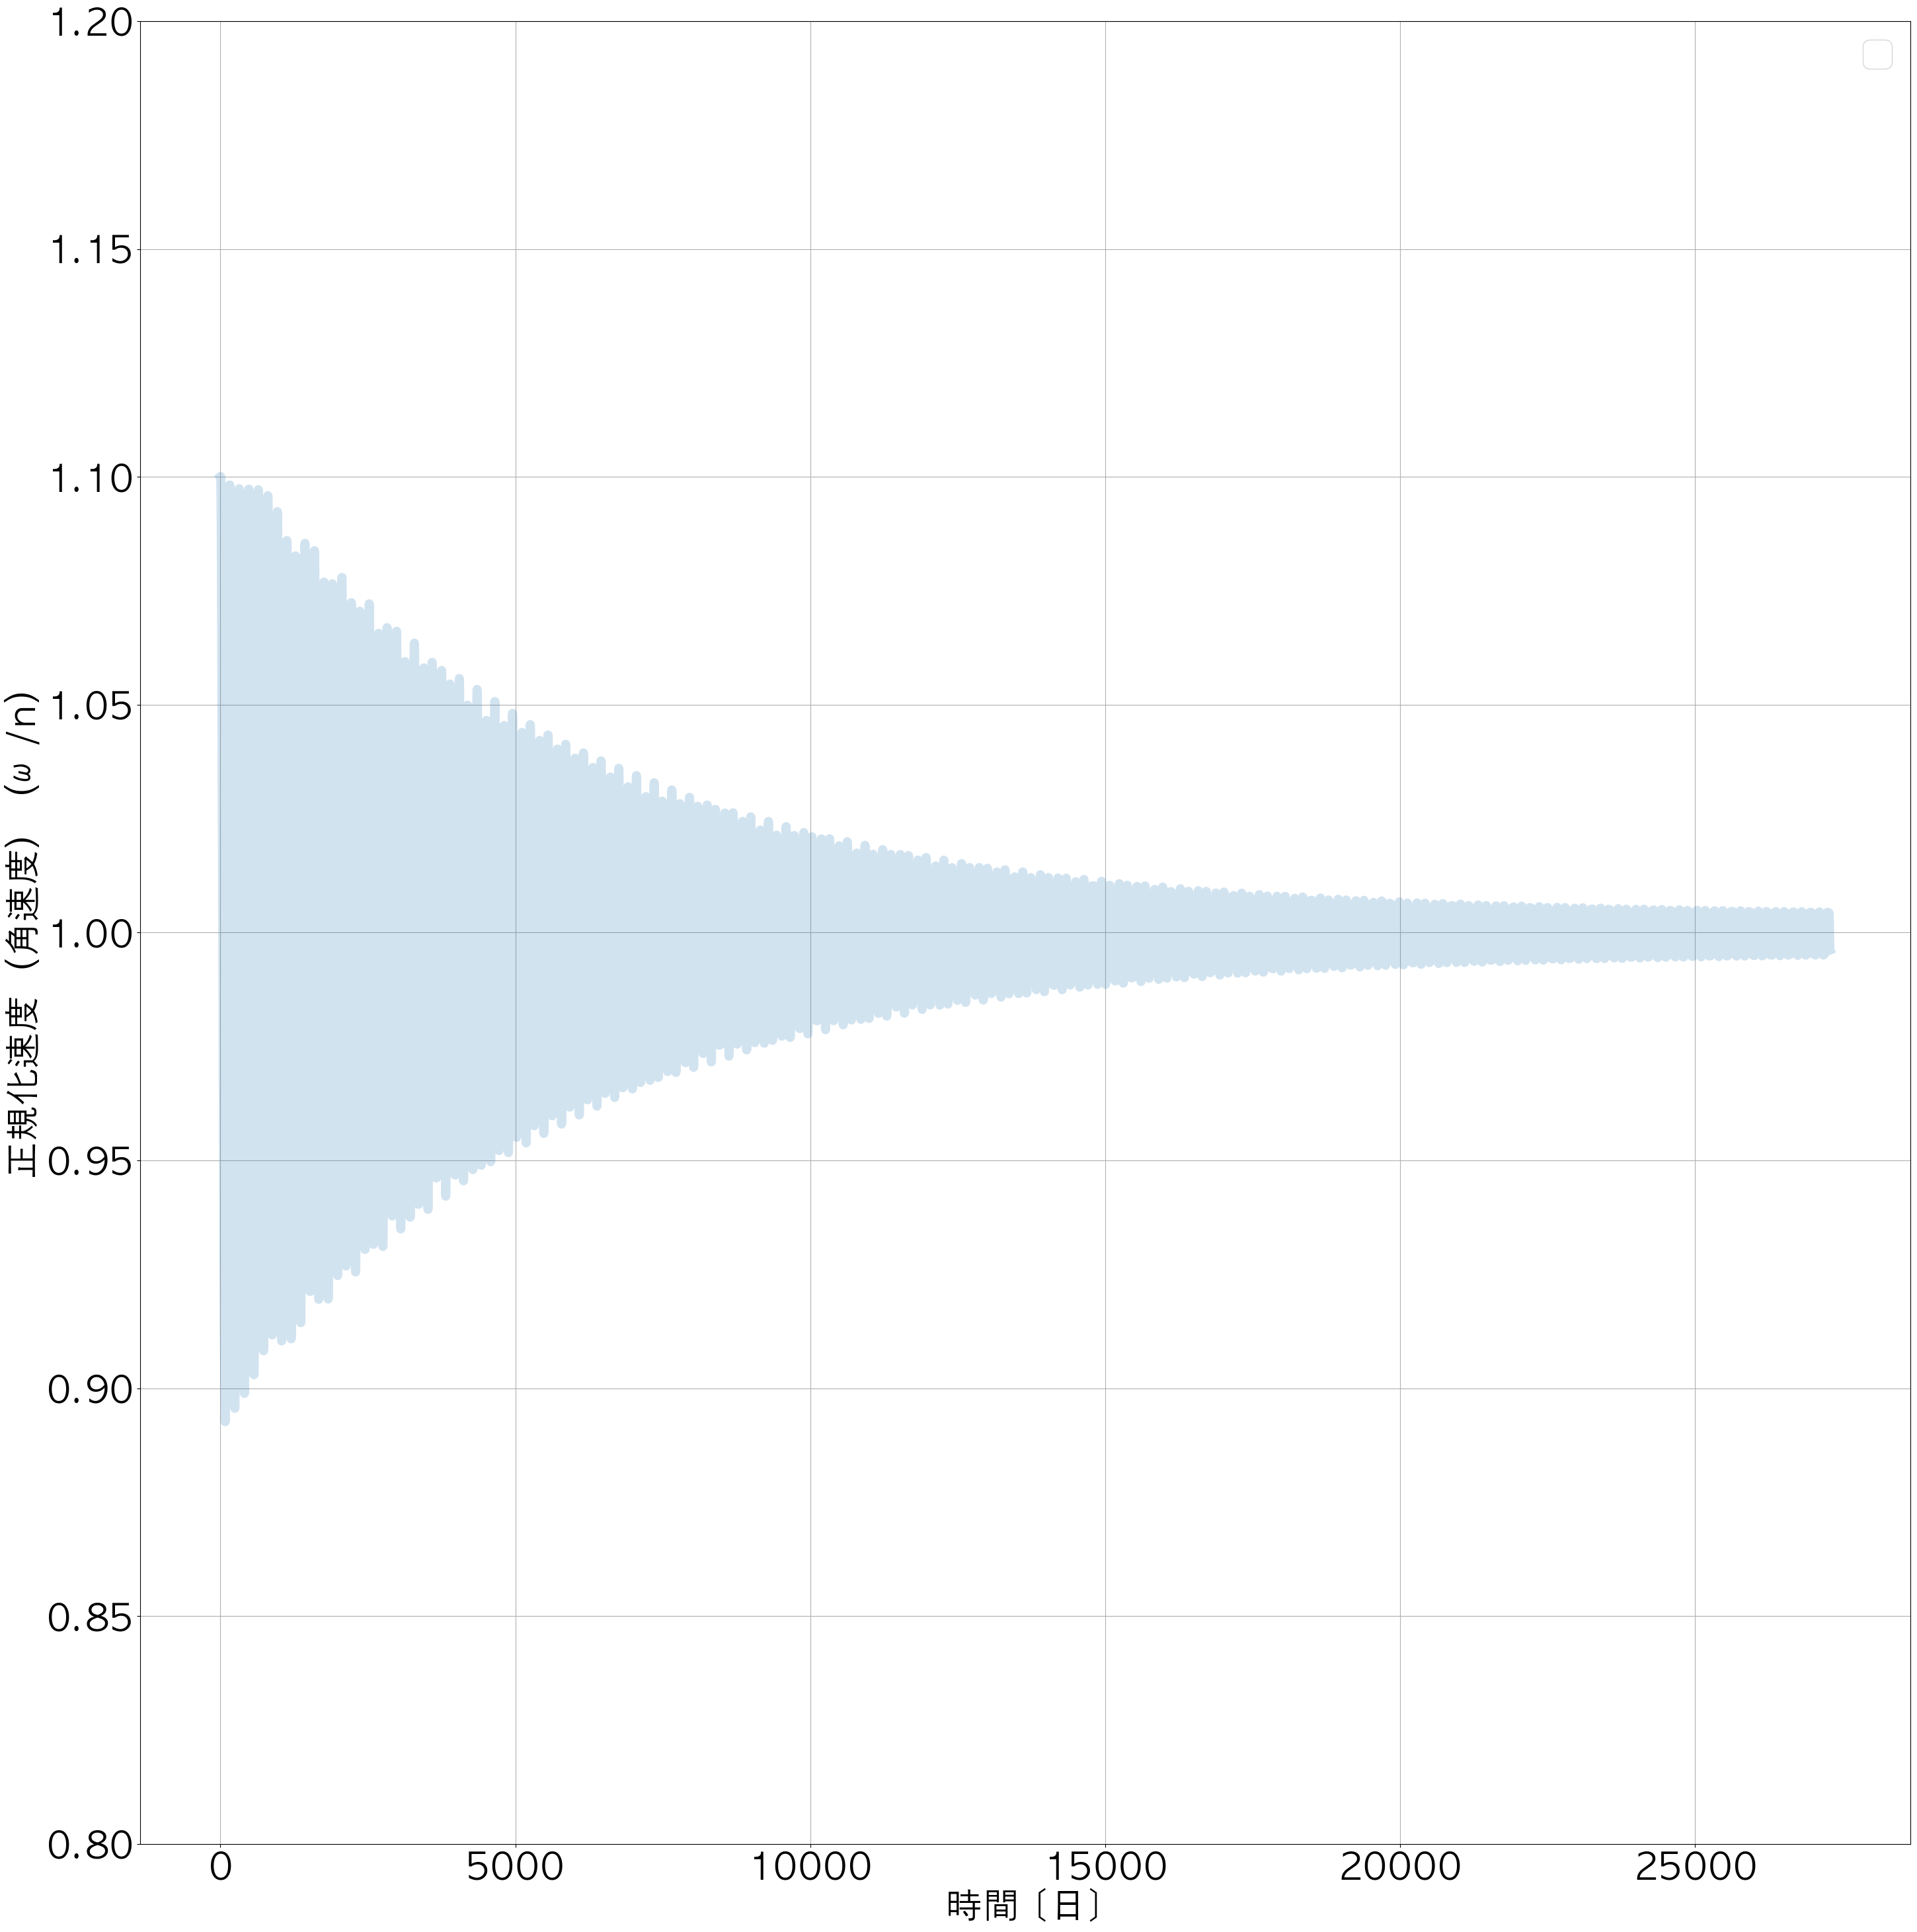

In [27]:
# 楕円軌道で表裏側の重さが違う場合
ts, omegas, f_dots, psis, n = simulation(e=0.055,omega_init=1.1,
    moment_rate=50,k2=1.0,dtau=1.0e7,t_total_factor=1000); results = []
results.append( {"ts":ts, 'omegas':omegas, 'f_dots':f_dots, 'psis':psis, "n":n, 'label': ''} ); plot_results(results)

/var/folders/mn/nmxx09wj21j7f81mwghvt1sw0000gn/T/ipykernel_15572/4193490467.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(); plt.grid(True); plt.tight_layout(); plt.ylim(0.8, 1.2); plt.show()  # 凡例、グリッド、表示


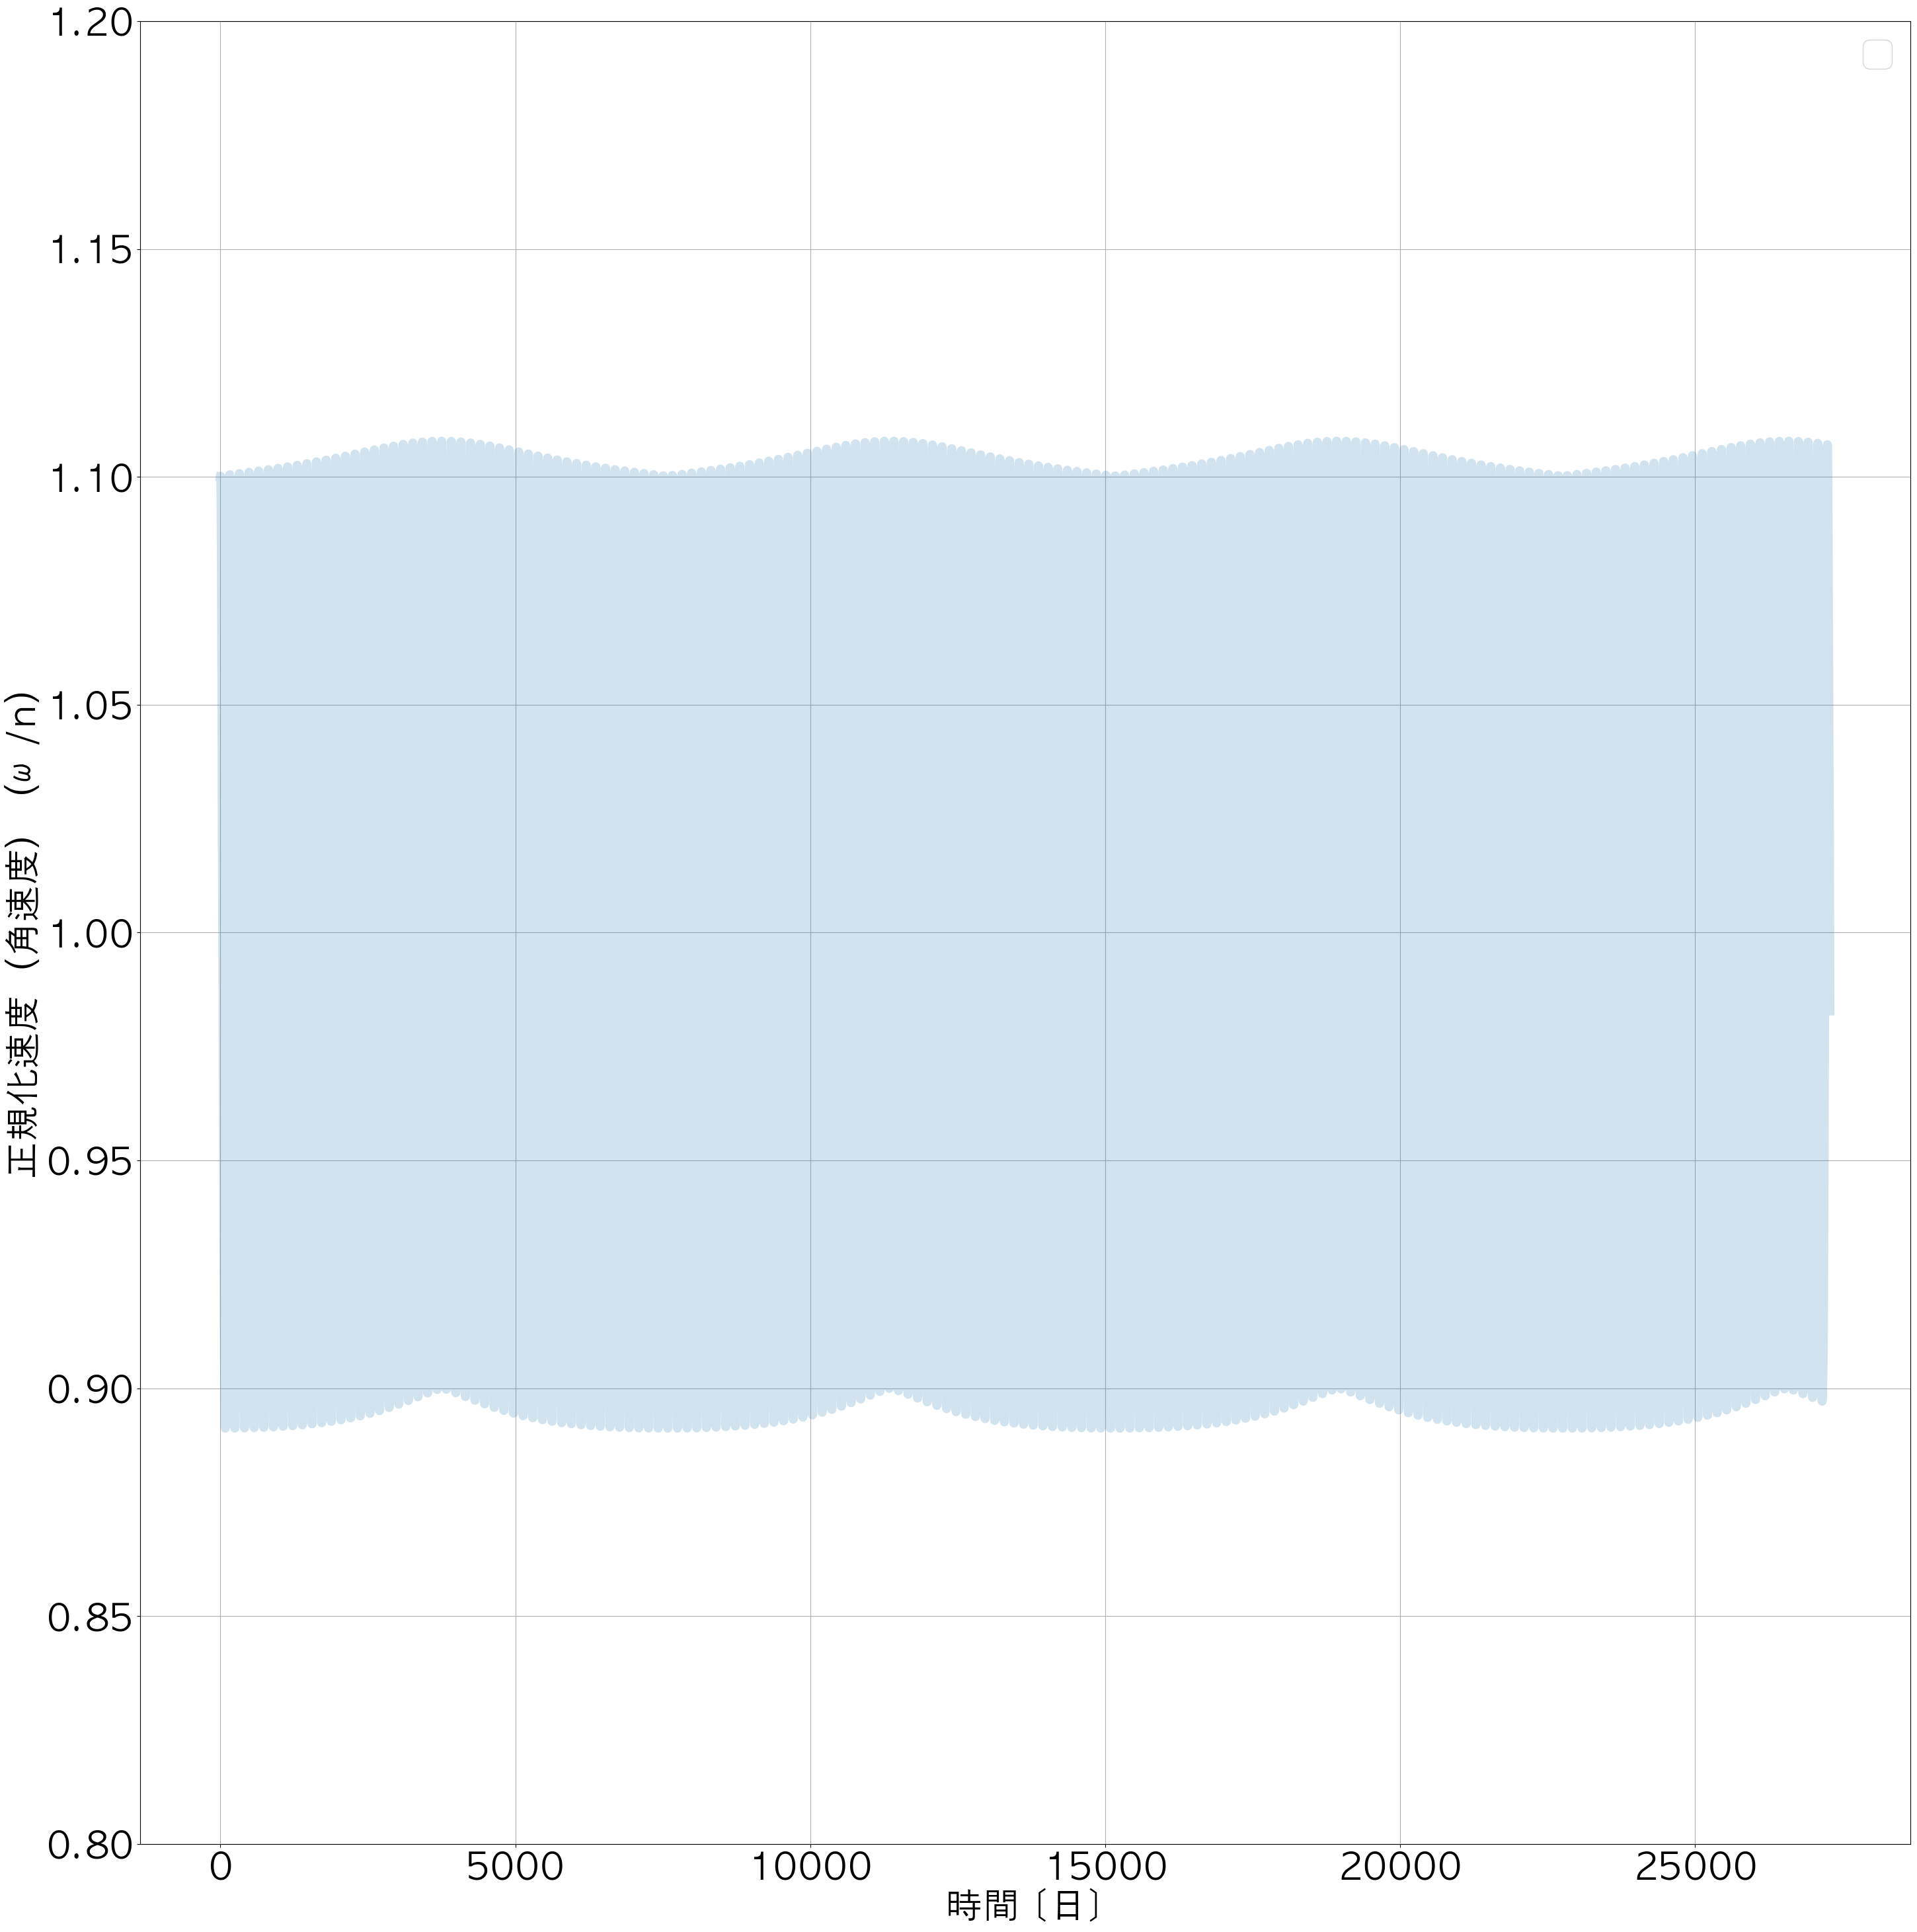

In [28]:
# 楕円軌道で表裏側の重さが違うが、朝夕変形影響は無視する場合
ts, omegas, f_dots, psis, n = simulation(e=0.055, omega_init=1.1,
    moment_rate=50, k2=1.0, dtau=0, t_total_factor=1000); results = []
results.append( {"ts":ts, 'omegas':omegas, 'f_dots':f_dots, 'psis':psis, "n":n, 'label': ''} ); plot_results(results)

In [10]:
import numpy as np; import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'AppleGothic'  # フォントをAppleGothicに設定
plt.rcParams['font.size'] = 40  # フォントサイズを40に設定
plt.rcParams["figure.figsize"]=30,30  # 図のサイズを30x30に設定

G = 6.67430e-11; M_e = 5.972e24; M_m = 7.342e22; R_m = 1.737e6  # 物理定数定義

def kepler_E(M, e, tol=1e-12, itmax=50):  # ケプラー方程式を解くための関数
    M = (M + np.pi) % (2*np.pi) - np.pi; E = M if e < 0.8 else np.pi  # M正規化、E初期化
    for _ in range(itmax):  # 最大50回繰り返し
        f = E - e*np.sin(E) - M; fp = 1 - e*np.cos(E); dE = -f/fp; E += dE  # ニュートン法
        if abs(dE) < tol:  # 収束判定
            break
    return E  # 偏心近点角Eを返す

def true_anomaly_and_radius(E, a, e):  # 真近点角と軌道半径を計算
    cosE, sinE = np.cos(E), np.sin(E); r = a*(1 - e*cosE); t = np.tan(E/2.0)       # rとtan(E/2)計算
    factor = np.sqrt((1+e)/(1-e)); f = 2*np.arctan2(factor*t, 1.0) % (2*np.pi)  # 真近点角f計算
    return f, r  # fとrを返す

def integrate_spin(omega0, theta0, a, e, BA=0.0, k2=0.03, dtau=1e4, t_total_factor=200.0, dt_factor=2000):  # 自転運動の積分
    n = np.sqrt(G*(M_e + M_m) / a**3)  # 平均運動nを計算
    T_orb = 2*np.pi / n; dt = T_orb / dt_factor; N = int(np.ceil((t_total_factor * T_orb) / dt))  # 時間設定
    theta = theta0; omega = omega0; M_mean = 0.0; Mdot = n; ts = np.empty(N)  # 初期化
    omegas = np.empty(N); f_dots = np.empty(N); psis = np.empty(N)  # 結果配列初期化
    for i in range(N):  # 時間ステップごとのループ
        t = i*dt; M_now = (M_mean + Mdot*dt) if i>0 else M_mean  # 時刻とM更新
        E = kepler_E(M_now, e); f, r = true_anomaly_and_radius(E, a, e)  # E, f, r計算
        f_dot = np.sqrt(G*(M_e + M_m)*a*(1-e**2)) / (r**2)  # 軌道角速度f_dot計算
        def rhs(theta, omega):  # 微分方程式の右辺
            Np = -1.5 * (G*M_e) / (r**3) * BA * np.sin(2.0*(theta - f)) if BA != 0.0 else 0.0  # 表側と裏側の重さの違いによる力（トルク）
            Nt = -3.0 * k2 * (G*(M_e**2)) * (R_m**5) * dtau * (omega - f_dot) / (r**6)          # 潮汐変形による力（トルク）
            domega = (Np + Nt) / (0.393 * M_m * R_m**2); dtheta = omega  # 角加速度とdθ/dt
            return dtheta, domega  # 微分値を返す
        k1t, k1w = rhs(theta, omega)                                         # 4次のルンゲクッタのk1計算
        k2t, k2w = rhs(theta + 0.5*dt*k1t, omega + 0.5*dt*k1w)  # 4次のルンゲクッタのk2計算
        k3t, k3w = rhs(theta + 0.5*dt*k2t, omega + 0.5*dt*k2w)  # 4次のルンゲクッタのk3計算
        k4t, k4w = rhs(theta + dt*k3t, omega + dt*k3w)              # 4次のルンゲクッタのk4計算
        theta += (dt/6.0)*(k1t + 2*k2t + 2*k3t + k4t)                  # 月の回転角度θ更新
        omega += (dt/6.0)*(k1w + 2*k2w + 2*k3w + k4w)           # ω更新
        M_mean = M_now; ts[i] = t; omegas[i] = omega; f_dots[i] = f_dot  # 結果保存
        psis[i] = (theta - f + np.pi) % (2*np.pi) - np.pi                  # 位相差ψ計算
    return ts, omegas, f_dots, psis

def simulation(e=0.055, omega_init=1.1, moment_rate=50, k2=0.024, dtau=500, t_total_factor=1000):
    a = 3.844e8; n = np.sqrt(G*(M_e + M_m) / a**3); T_orb = 2*np.pi / n  # 軌道パラメータ
    omega0 = omega_init * n; theta0 = 0.0; C = 0.393 * M_m * R_m**2    # 初期条件
    moment = 2.3e-4 * C * moment_rate  # 表側と裏側の重さ違いによる慣性モーメント差
    ts, omegas, f_dots, psis = integrate_spin(omega0, theta0, a, e, BA=moment, k2=k2, dtau=dtau, 
                                              t_total_factor=t_total_factor, dt_factor=2000)  # 積分実行
    return (ts, omegas, f_dots, psis, n)  # 結果を返す

def plot_results(results):  # 結果をプロット
    for result in results:    # 複数計算対応（本記事では使っていません）
        plt.plot(result['ts']/86400.0, result['omegas']/result['n'], label=result['label'], linewidth=10, alpha=0.2) 
    plt.xlabel('時間 [日]'); plt.ylabel('正規化速度（角速度） (ω/n)')  # 軸ラベル設定
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.ylim(0.8, 1.2); plt.show()  # 凡例、グリッド、表示

/var/folders/mn/nmxx09wj21j7f81mwghvt1sw0000gn/T/ipykernel_15572/4193490467.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(); plt.grid(True); plt.tight_layout(); plt.ylim(0.8, 1.2); plt.show()  # 凡例、グリッド、表示


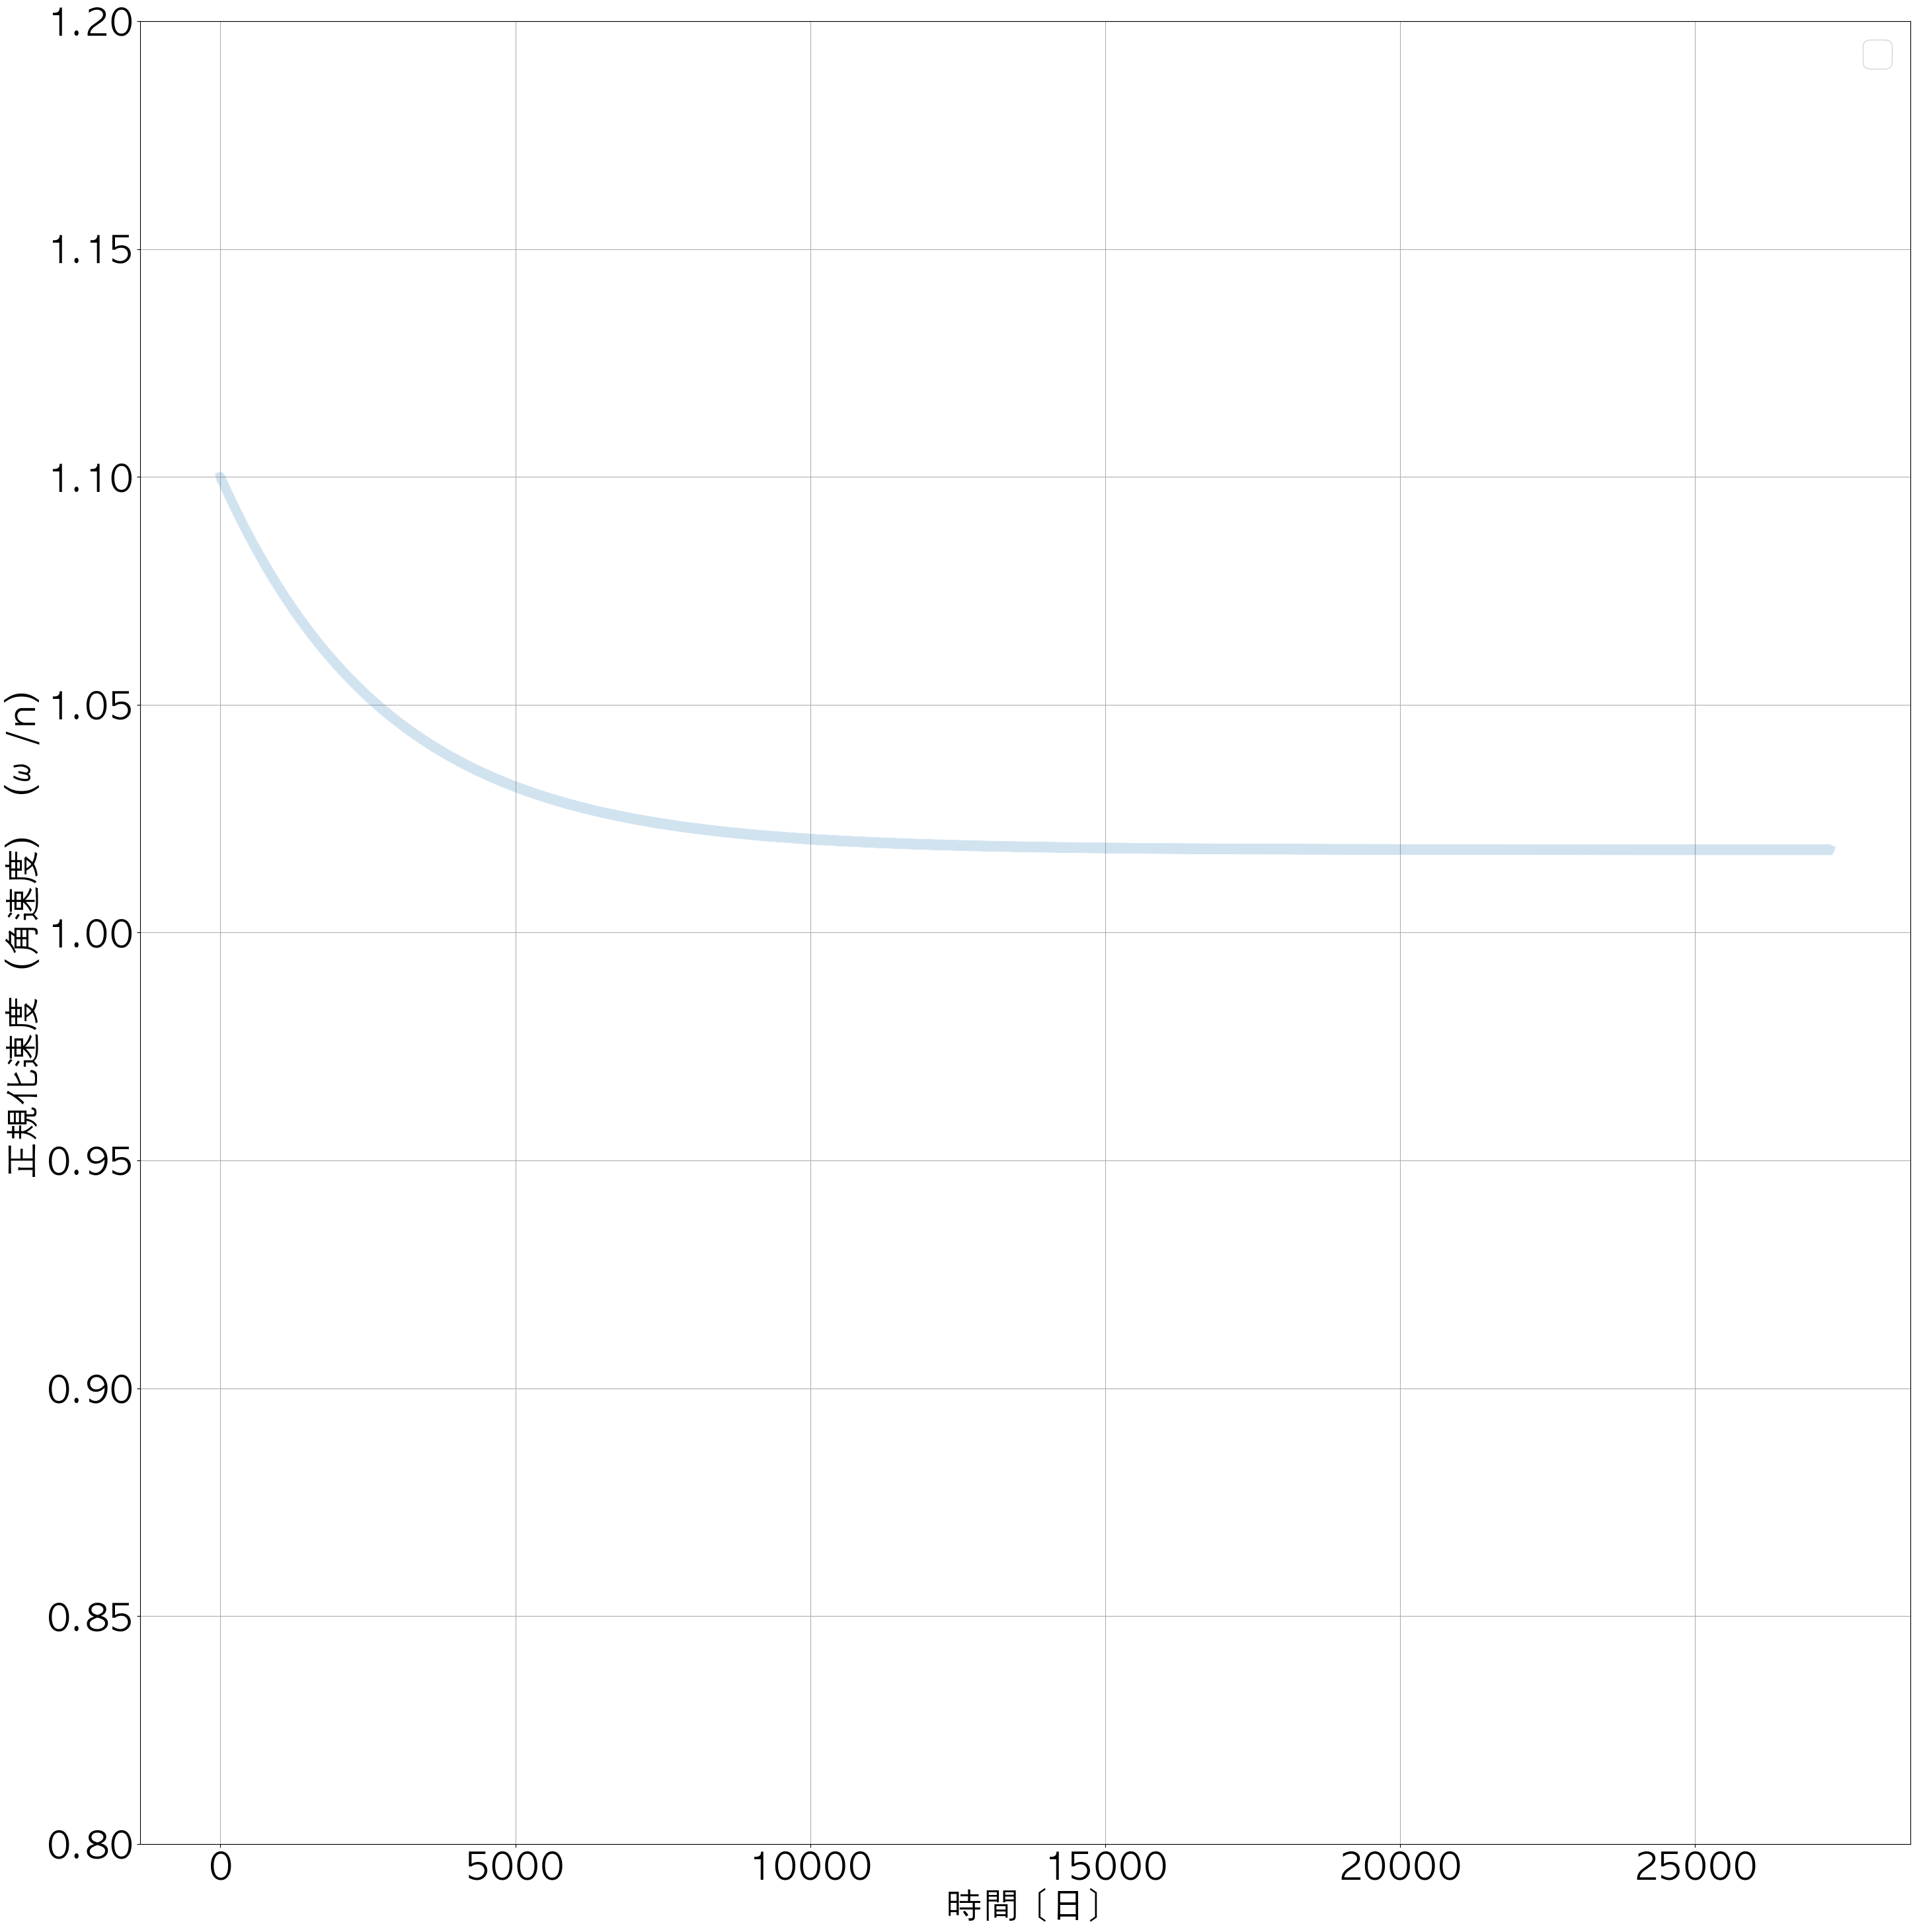

In [24]:
# 楕円軌道で表裏側の重さが同じ場合
ts, omegas, f_dots, psis, n = simulation(e=0.055,omega_init =1.1,moment_rate=0,k2=1.0, dtau=1.0e7,t_total_factor=1000)
results = []; results.append( {"ts":ts, 'omegas':omegas, 'f_dots':f_dots, 'psis':psis, "n":n, 'label': ''} ); plot_results(results)

/var/folders/mn/nmxx09wj21j7f81mwghvt1sw0000gn/T/ipykernel_15572/4236101543.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(); plt.grid(True); plt.tight_layout(); plt.ylim(0.8, 1.2); plt.show()  # 凡例、グリッド、表示


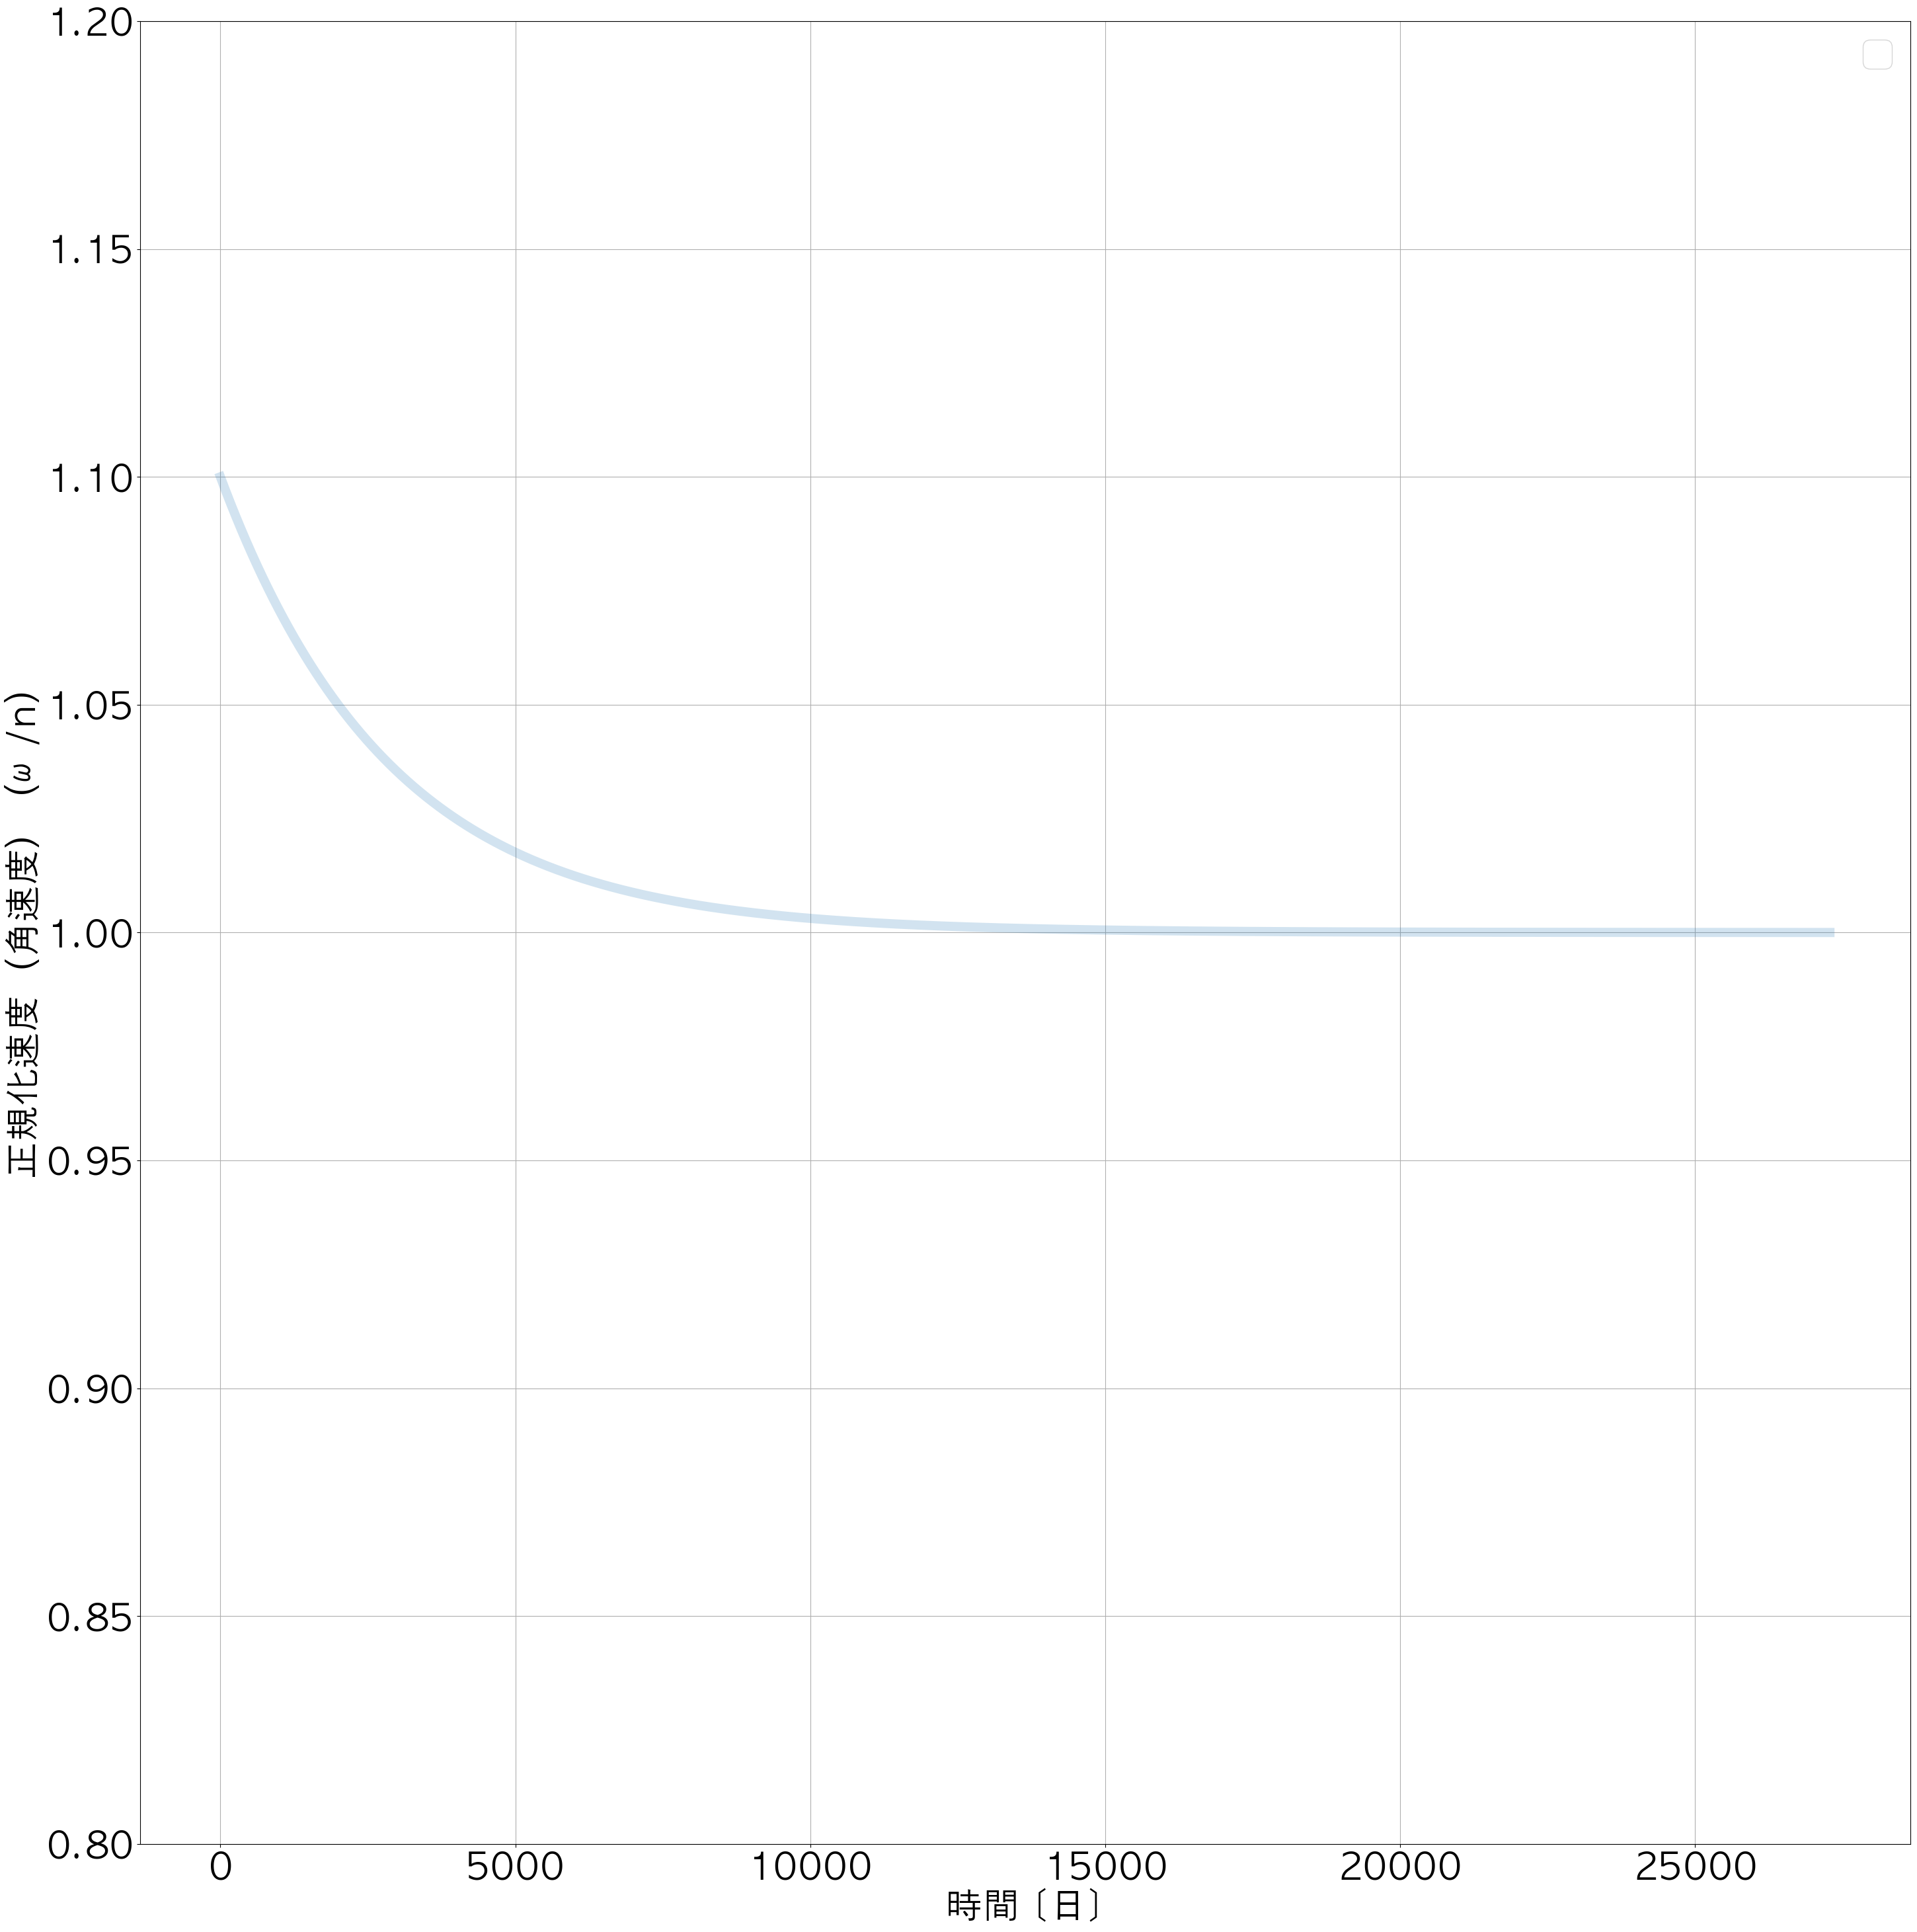

In [18]:
# 円軌道で表裏側の重さが同じ場合
ts, omegas, f_dots, psis, n = simulation(e=0.0, omega_init=1.1, moment_rate=0, k2=1.0, dtau=1.0e7, t_total_factor=1000)
results = []; results.append( {"ts":ts, 'omegas':omegas, 'f_dots':f_dots, 'psis':psis, "n":n, 'label': ''} ); plot_results(results)

/var/folders/mn/nmxx09wj21j7f81mwghvt1sw0000gn/T/ipykernel_15572/4236101543.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(); plt.grid(True); plt.tight_layout(); plt.ylim(0.8, 1.2); plt.show()  # 凡例、グリッド、表示


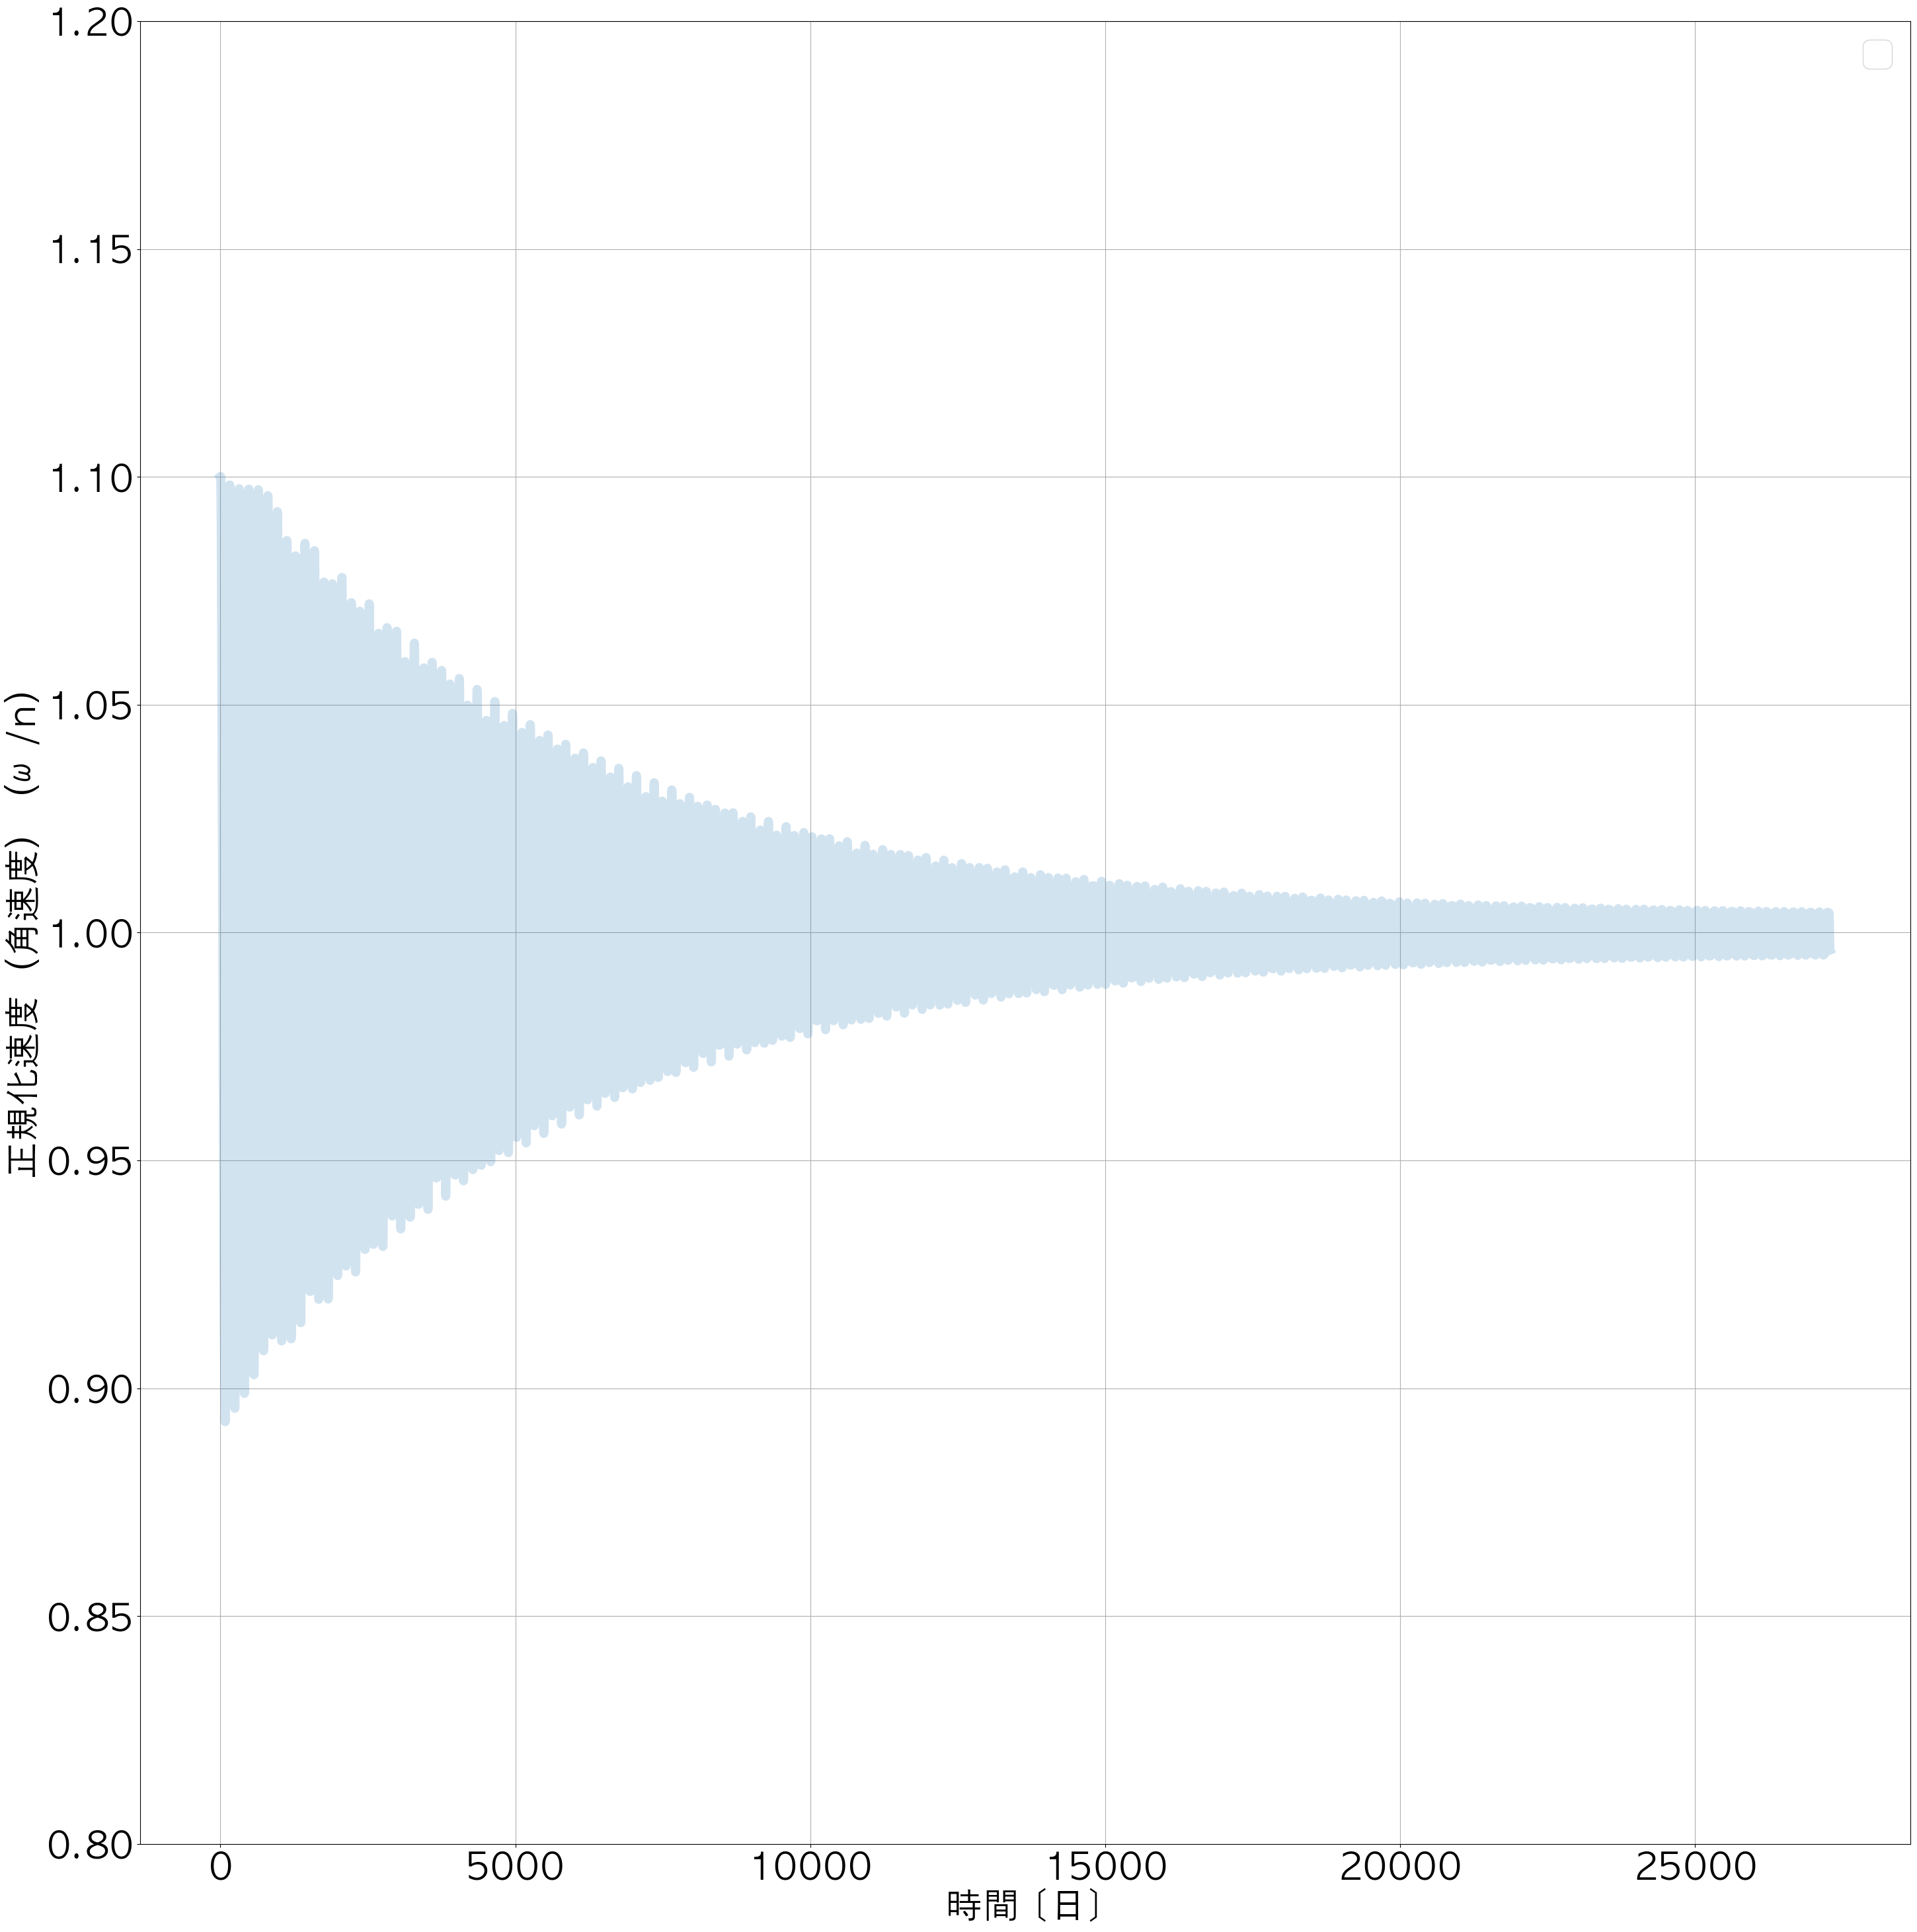

In [19]:
# 楕円軌道で表裏側の重さが違う場合
ts, omegas, f_dots, psis, n = simulation(e=0.055,omega_init=1.1,moment_rate=50,k2=1.0,dtau=1.0e7,t_total_factor=1000)
results = []; results.append( {"ts":ts, 'omegas':omegas, 'f_dots':f_dots, 'psis':psis, "n":n, 'label': ''} ); plot_results(results)

/var/folders/mn/nmxx09wj21j7f81mwghvt1sw0000gn/T/ipykernel_15572/4236101543.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(); plt.grid(True); plt.tight_layout(); plt.ylim(0.8, 1.2); plt.show()  # 凡例、グリッド、表示


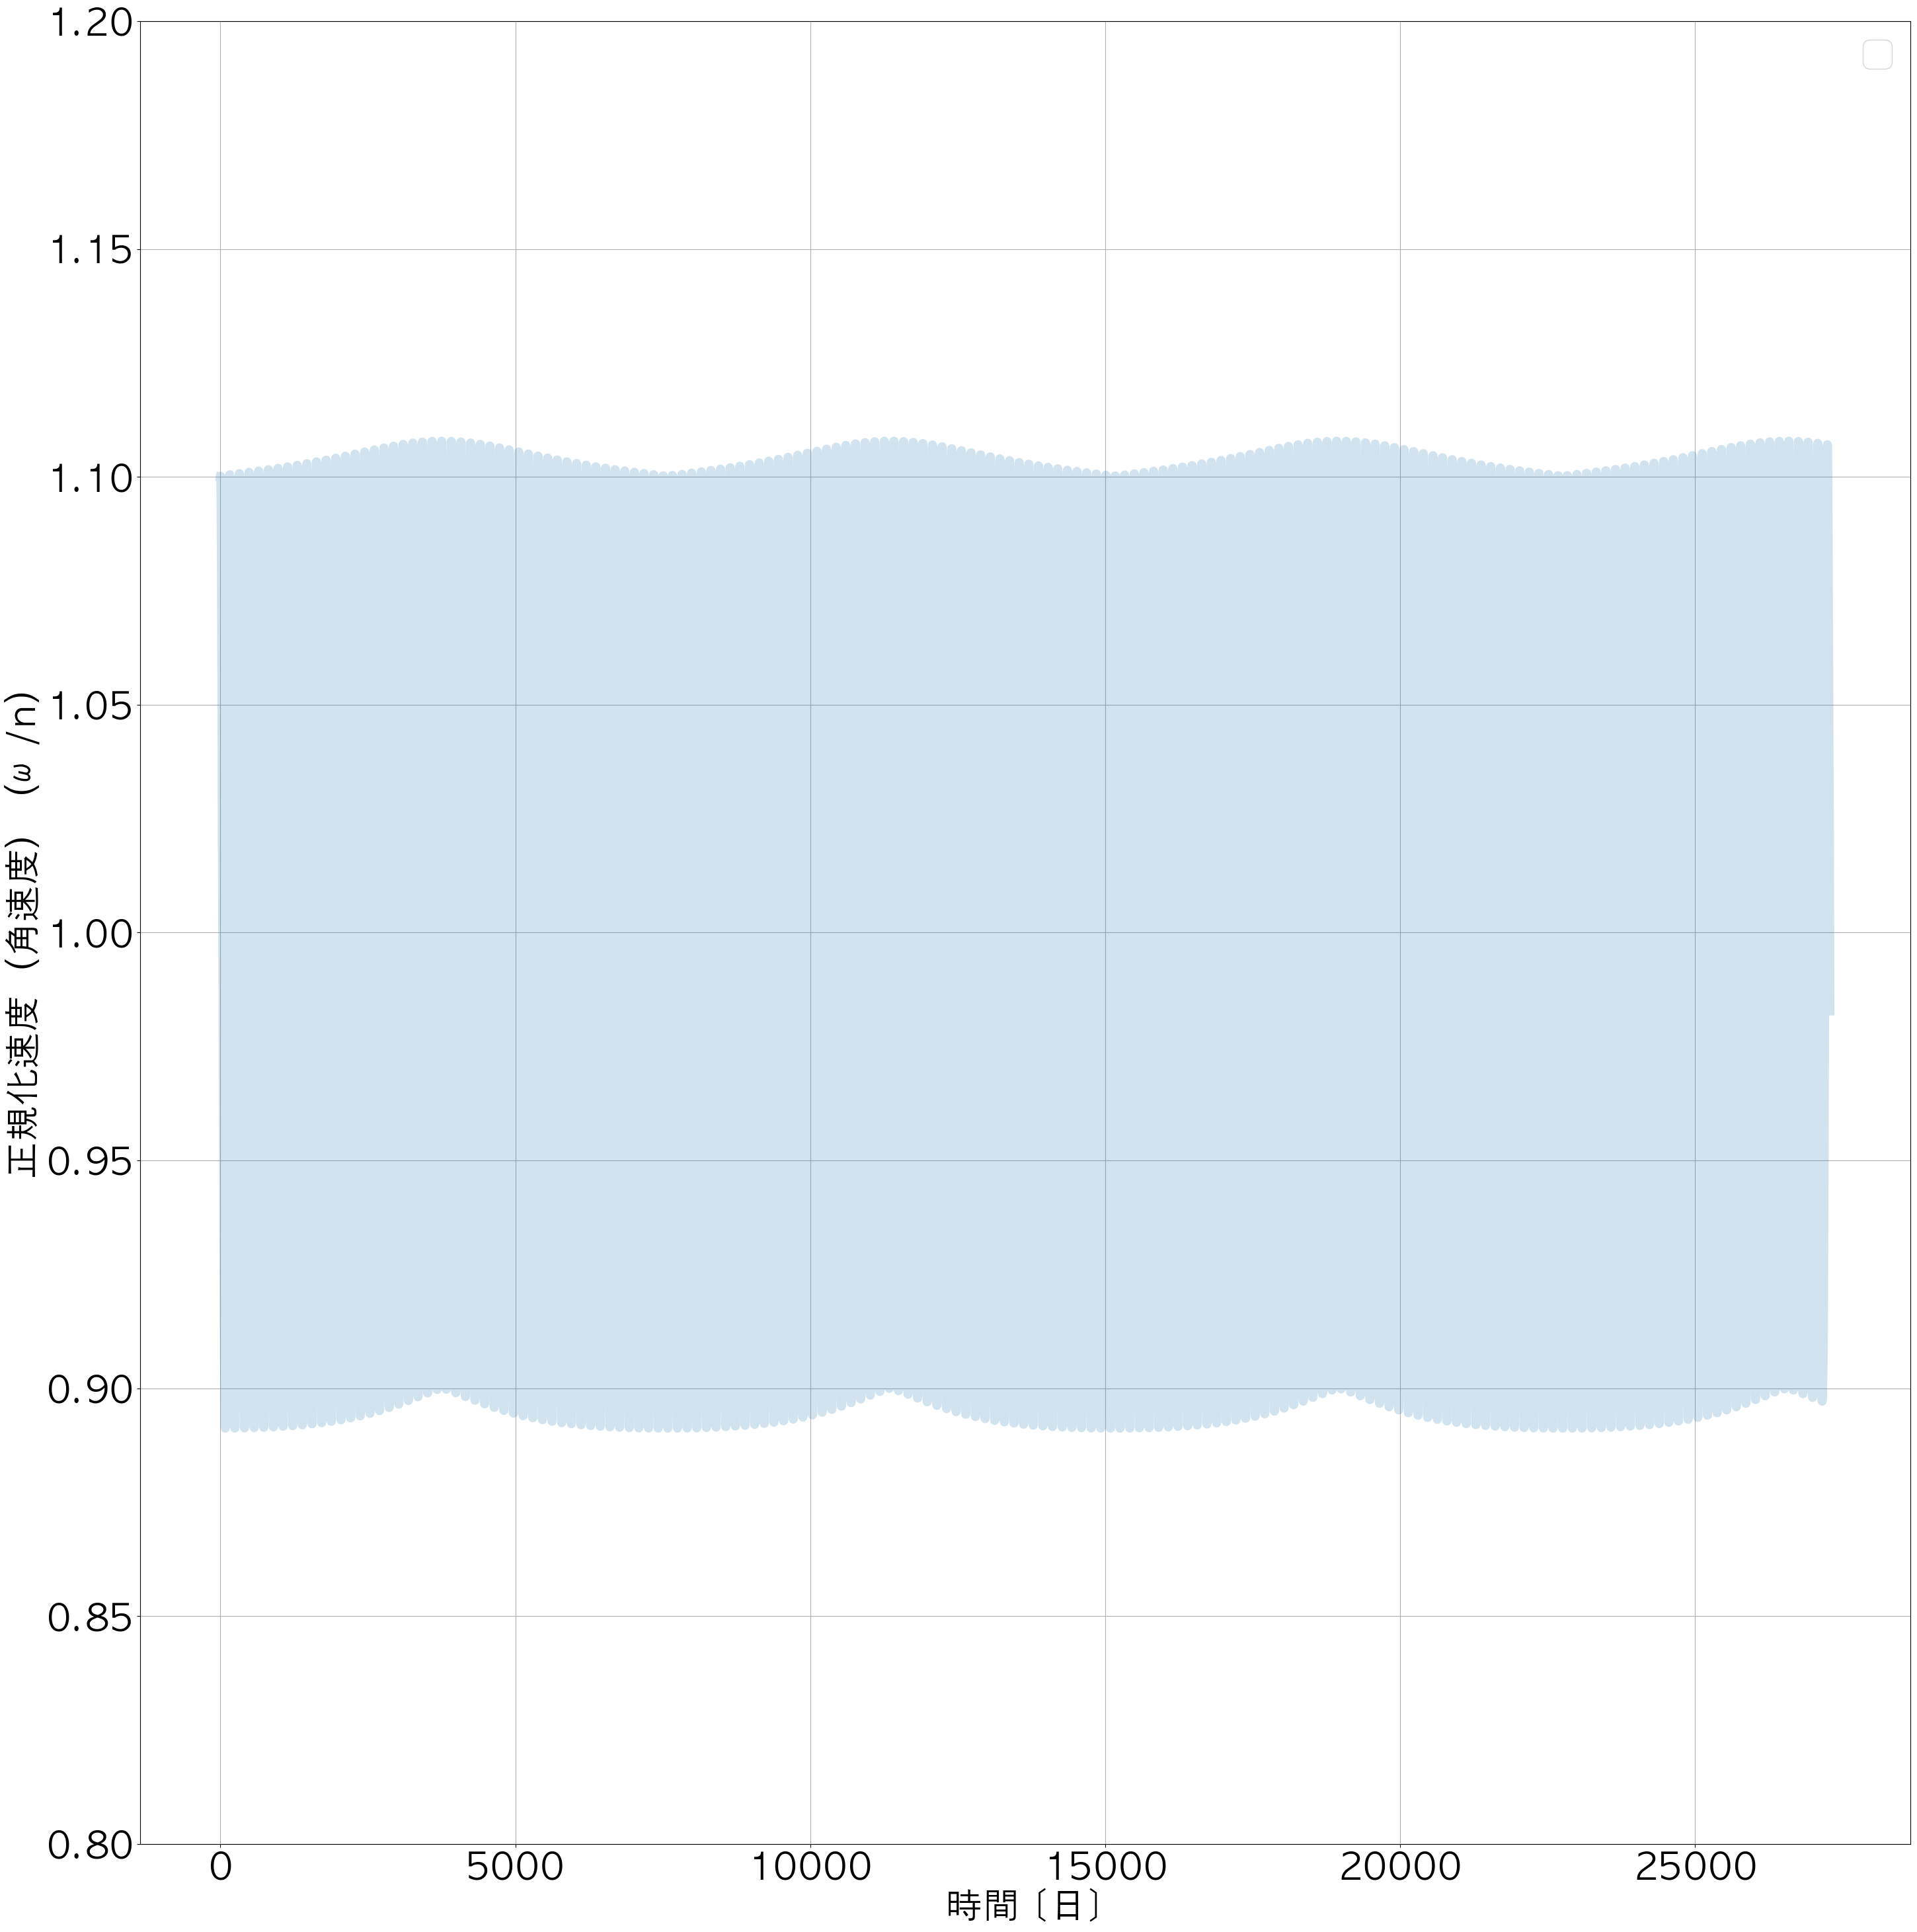

In [20]:
# 楕円軌道で表裏側の重さが違うが朝夕変形影響を無視する場合
ts, omegas, f_dots, psis, n = simulation(e=0.055, omega_init=1.1, moment_rate=50, k2=1.0, dtau=0, t_total_factor=1000)
results = []; results.append( {"ts":ts, 'omegas':omegas, 'f_dots':f_dots, 'psis':psis, "n":n, 'label': ''} ); plot_results(results)

## 記事原稿用

In [7]:
import numpy as np  # NumPyライブラリをインポート（数値計算用）
import matplotlib.pyplot as plt  # プロット用ライブラリをインポート

plt.rcParams['font.family'] = 'AppleGothic'  # フォントをAppleGothicに設定
plt.rcParams['font.size'] = 40  # フォントサイズを40に設定
plt.rcParams["figure.figsize"]=30,30  # 図のサイズを30x30に設定

G = 6.67430e-11; M_e = 5.972e24; M_m = 7.342e22; R_m = 1.737e6  # 物理定数定義

def kepler_E(M, e, tol=1e-12, itmax=50):  # ケプラー方程式を解く関数
    M = (M + np.pi) % (2*np.pi) - np.pi; E = M if e < 0.8 else np.pi  # M正規化、E初期化
    for _ in range(itmax):  # 最大50回繰り返し
        f = E - e*np.sin(E) - M; fp = 1 - e*np.cos(E); dE = -f/fp; E += dE  # ニュートン法
        if abs(dE) < tol:  # 収束判定
            break
    return E  # 偏心近点角Eを返す

def true_anomaly_and_radius(E, a, e):  # 真近点角と軌道半径を計算
    cosE, sinE = np.cos(E), np.sin(E); r = a*(1 - e*cosE); t = np.tan(E/2.0)  # rとtan(E/2)計算
    factor = np.sqrt((1+e)/(1-e)); f = 2*np.arctan2(factor*t, 1.0) % (2*np.pi)  # 真近点角f計算
    return f, r  # fとrを返す

def integrate_spin(omega0, theta0, a, e, BA=0.0, k2=0.03, dtau=1e4, t_total_factor=200.0, dt_factor=2000):  # 自転運動の積分
    n = np.sqrt(G*(M_e + M_m) / a**3)  # 平均運動nを計算
    T_orb = 2*np.pi / n; dt = T_orb / dt_factor; N = int(np.ceil((t_total_factor * T_orb) / dt))  # 時間設定
    theta = theta0; omega = omega0; M_mean = 0.0; Mdot = n; ts = np.empty(N)  # 初期化
    omegas = np.empty(N); f_dots = np.empty(N); psis = np.empty(N)  # 結果配列初期化
    for i in range(N):  # 時間ステップごとのループ
        t = i*dt; M_now = (M_mean + Mdot*dt) if i>0 else M_mean  # 時刻とM更新
        E = kepler_E(M_now, e); f, r = true_anomaly_and_radius(E, a, e)  # E, f, r計算
        f_dot = np.sqrt(G*(M_e + M_m)*a*(1-e**2)) / (r**2)  # 軌道角速度f_dot計算
        def rhs(theta, omega):  # 微分方程式の右辺
            Np = -1.5 * (G*M_e) / (r**3) * BA * np.sin(2.0*(theta - f)) if BA != 0.0 else 0.0  # 永久形状トルク
            Nt = -3.0 * k2 * (G*(M_e**2)) * (R_m**5) * dtau * (omega - f_dot) / (r**6)  # 潮汐トルク
            domega = (Np + Nt) / (0.393 * M_m * R_m**2); dtheta = omega  # 角加速度とdθ/dt
            return dtheta, domega  # 微分値を返す
        k1t, k1w = rhs(theta, omega)  # RK4のk1計算
        k2t, k2w = rhs(theta + 0.5*dt*k1t, omega + 0.5*dt*k1w)  # RK4のk2計算
        k3t, k3w = rhs(theta + 0.5*dt*k2t, omega + 0.5*dt*k2w)  # RK4のk3計算
        k4t, k4w = rhs(theta + dt*k3t, omega + dt*k3w)  # RK4のk4計算
        theta += (dt/6.0)*(k1t + 2*k2t + 2*k3t + k4t)  # θ更新
        omega += (dt/6.0)*(k1w + 2*k2w + 2*k3w + k4w)  # ω更新
        M_mean = M_now; ts[i] = t; omegas[i] = omega; f_dots[i] = f_dot  # 結果保存
        psis[i] = (theta - f + np.pi) % (2*np.pi) - np.pi  # 位相差ψ計算
    return ts, omegas, f_dots, psis  # 結果を返す

def simulation(e=0.055, omega_init=1.1, moment_rate=50, k2=0.024, dtau=500, t_total_factor=1000):  # シミュレーション関数
    a = 3.844e8; n = np.sqrt(G*(M_e + M_m) / a**3); T_orb = 2*np.pi / n  # 軌道パラメータ
    omega0 = omega_init * n; theta0 = 0.0; C = 0.393 * M_m * R_m**2  # 初期条件
    moment = 2.3e-4 * C * moment_rate  # 慣性モーメント差
    ts, omegas, f_dots, psis = integrate_spin(omega0, theta0, a, e, BA=moment, k2=k2, dtau=dtau, 
                                              t_total_factor=t_total_factor, dt_factor=2000)  # 積分実行
    return (ts, omegas, f_dots, psis, n)  # 結果を返す

def plot_results(results):  # 結果をプロット
    for result in results:  # 各結果をループ
        plt.plot(result['ts']/86400.0, result['omegas']/result['n'], label=result['label'], linewidth=10, alpha=0.2)  # 角速度をプロット
    plt.xlabel('時間 [日]'); plt.ylabel('正規化速度（角速度） (ω/n)')  # 軸ラベル設定
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.ylim(0.8, 1.2); plt.show()  # 凡例、グリッド、表示

/var/folders/mn/nmxx09wj21j7f81mwghvt1sw0000gn/T/ipykernel_15572/3161134468.py:64: UserWarning: Glyph 22793 (\N{CJK UNIFIED IDEOGRAPH-5909}) missing from font(s) AppleGothic.
  plt.legend(); plt.grid(True); plt.tight_layout(); plt.ylim(0.8, 1.2); plt.show()


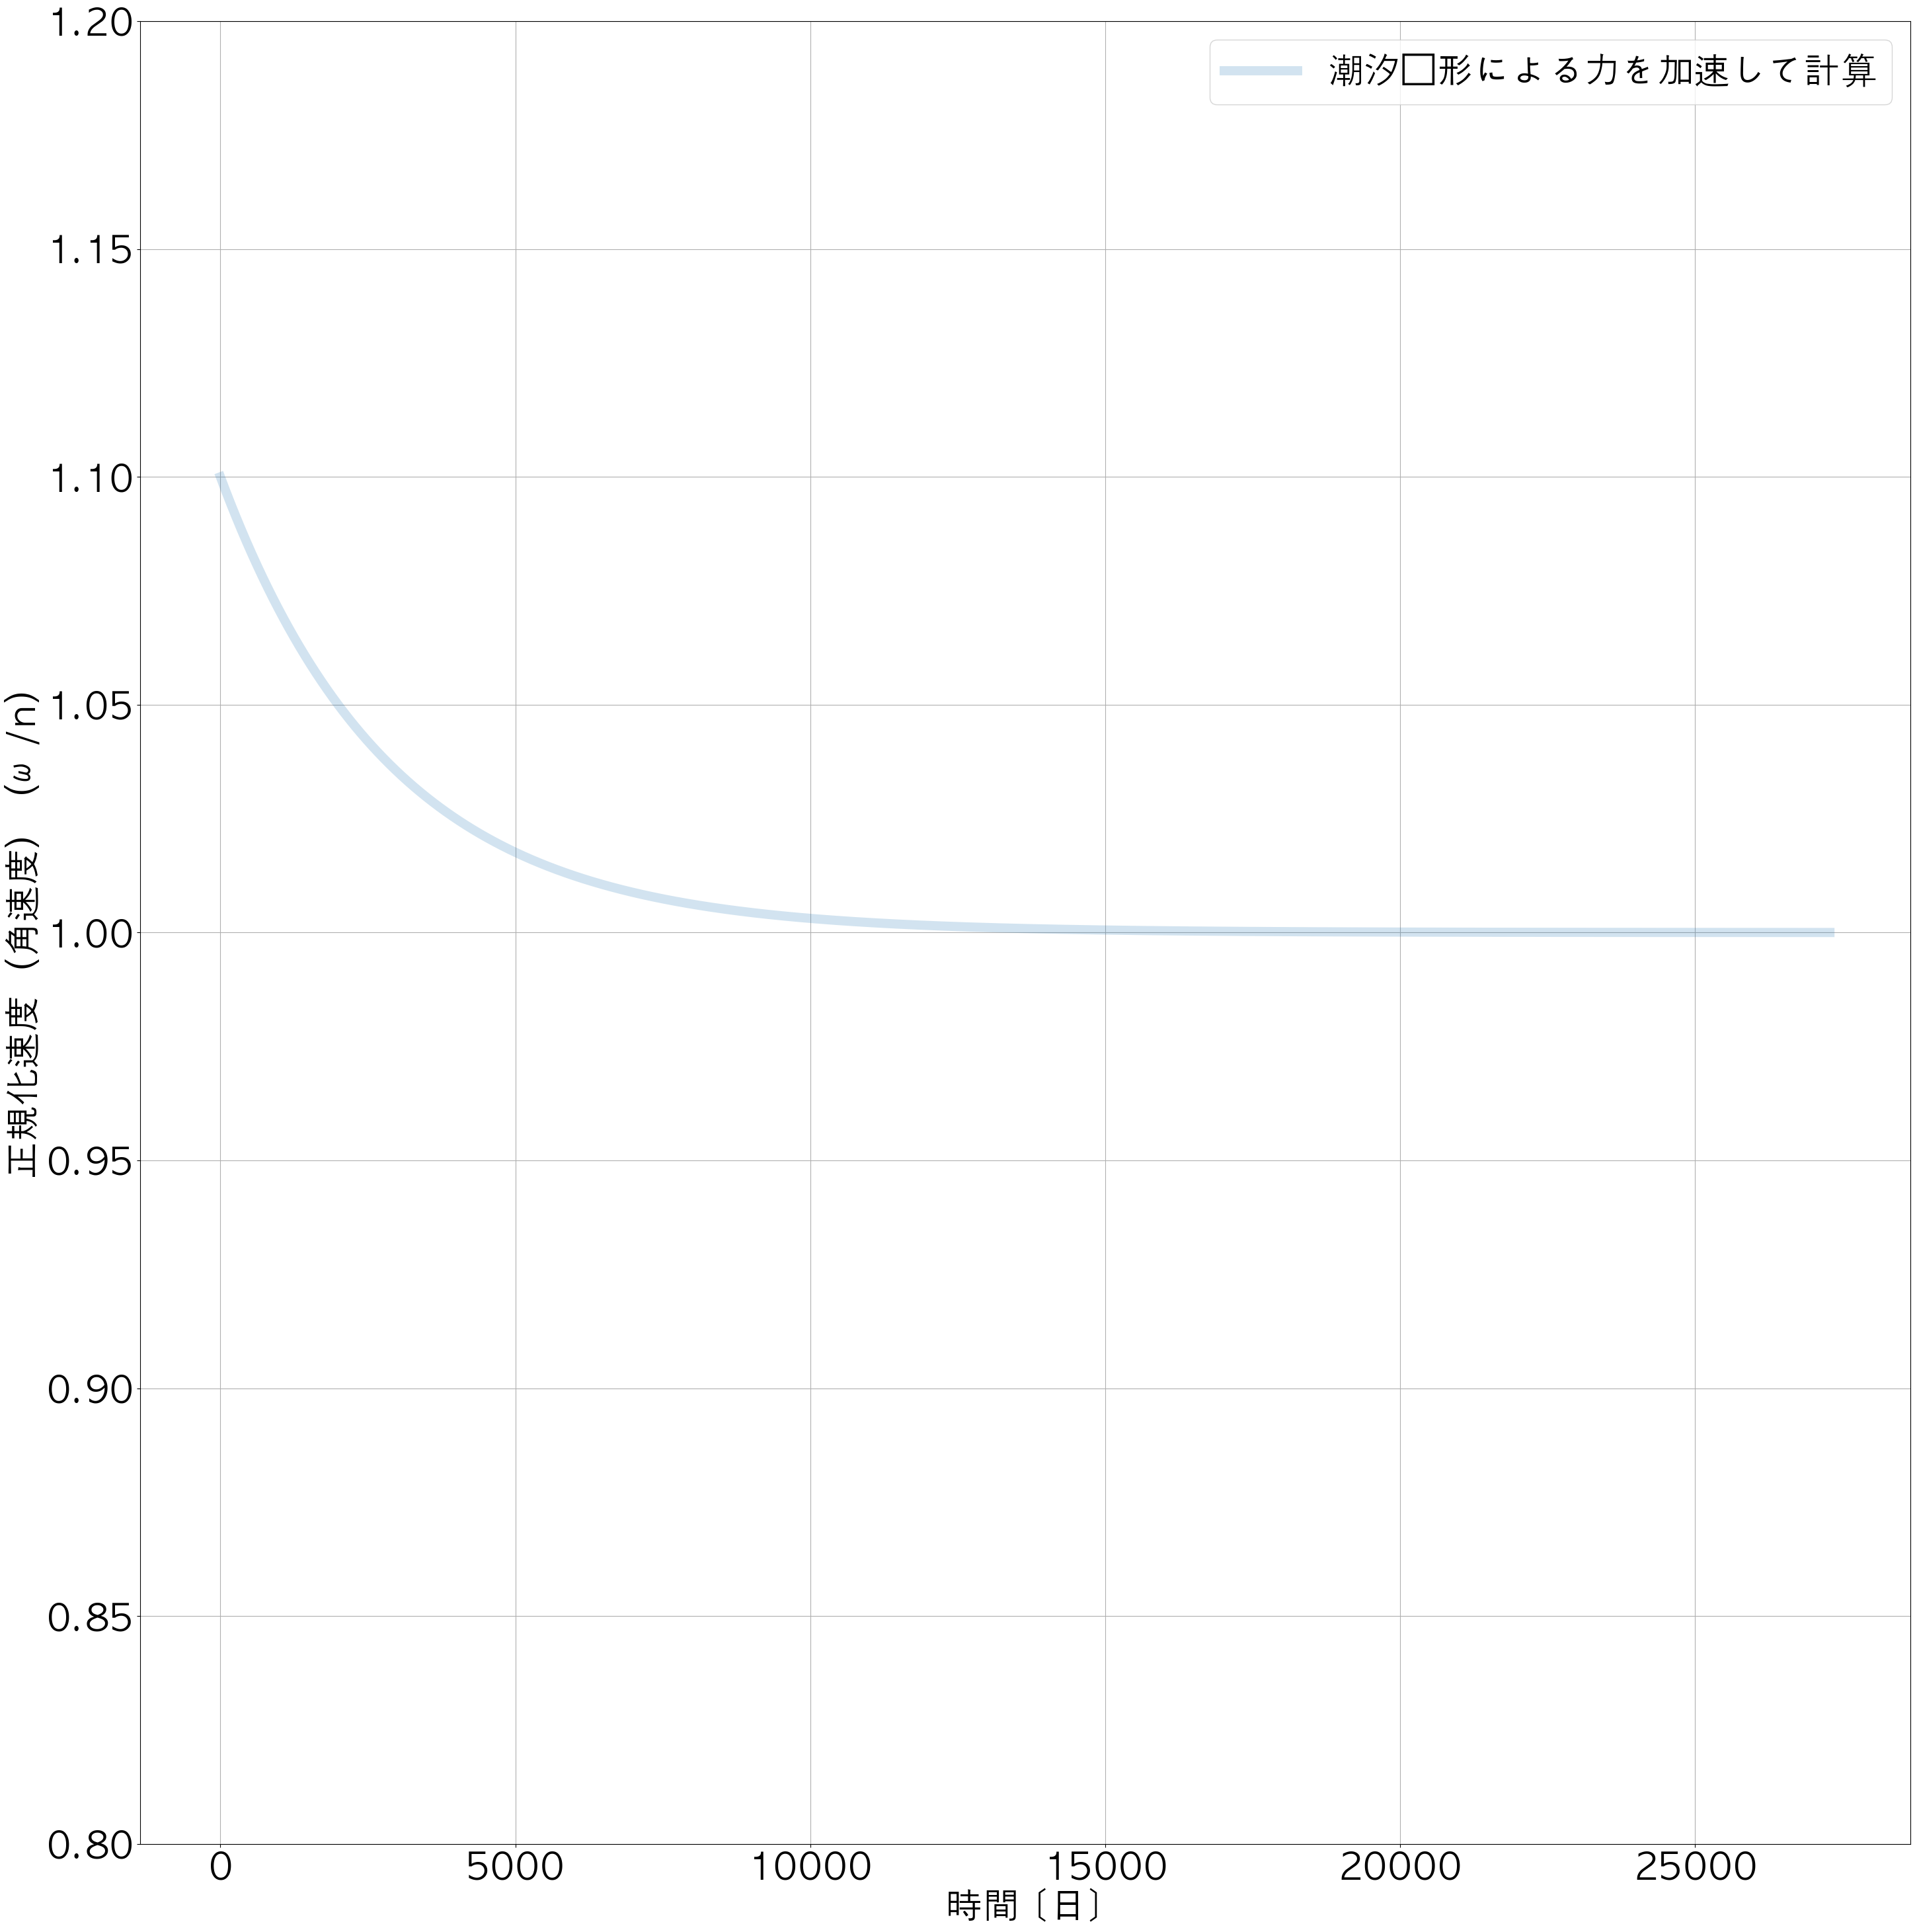

In [8]:
# 楕円軌道＆表裏側の重さが同じ場合
ts, omegas, f_dots, psis, n = simulation(e=0.0, omega_init=1.1, moment_rate=0, k2=1.0,  dtau=1.0e7, t_total_factor=1000)
results = []
results.append( {"ts":ts, 'omegas':omegas, 'f_dots':f_dots, 'psis':psis, "n":n, 'label': '潮汐変形による力を加速して計算'} )
plot_results(results)

## 計算実行用

/var/folders/mn/nmxx09wj21j7f81mwghvt1sw0000gn/T/ipykernel_10633/4050426387.py:316: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


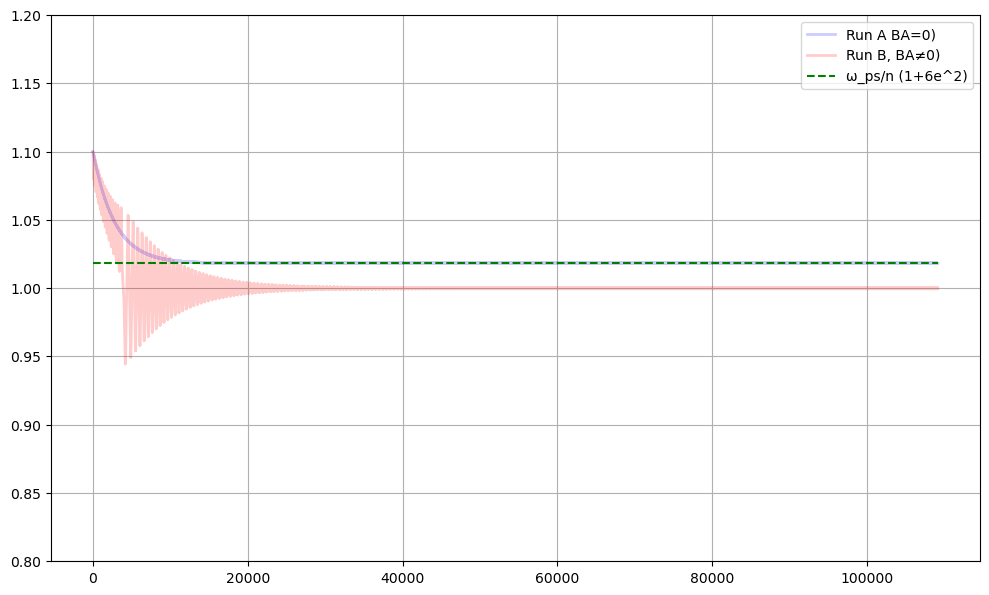

小離心率解析の擬似同期係数 (1+6 e^2) = 1.018
Run A (潮汐のみ, BA=0) 最終 ω/n = 0.918
Run B (BA≠0, 現実的) 最終 ω/n = 0.902


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# --- 物理定数 (SI単位) ---
# 解説: 物理定数を定義。地球-月系をモデル化し、月の自転運動をシミュレート。
# - G: 万有引力定数 (m^3 kg^-1 s^-2)
# - M_e: 地球の質量 (kg)
# - M_m: 月の質量 (kg)
# - R_m: 月の半径 (m)
# 物理的意味: これらの定数は、軌道運動（ケプラー軌道）とトルク計算に使用され、地球-月間の重力相互作用や月の慣性モーメントを決定。
G = 6.67430e-11
M_e = 5.972e24       # 地球の質量
M_m = 7.342e22       # 月の質量
R_m = 1.737e6        # 月の半径

# --- 軌道/慣性モーメントのヘルパー関数 ---
# 関数: mean_motion(a)
# 解説: 軌道の平均運動（n = √(μ/a^3)）を計算。μは重力パラメータ（G*(M_e + M_m)）。
# 物理的意味: 平均運動nは、楕円軌道の角速度の基準。月の軌道周期（T_orb = 2π/n）はこのnに基づく。
def mean_motion(a):
    mu = G*(M_e + M_m)
    return np.sqrt(mu / a**3)

# 関数: kepler_E(M, e, tol=1e-12, itmax=50)
# 解説: ケプラー方程式（M = E - e*sin(E)）をニュートン法で解き、偏心近点角Eを計算。
# - M: 平均近点角
# - e: 離心率
# 物理的意味: 楕円軌道では、時間（平均近点角M）から位置（偏心近点角E）を計算する必要がある。e=0.055（月の軌道）により、軌道はわずかに楕円形。
def kepler_E(M, e, tol=1e-12, itmax=50):
    M = (M + np.pi) % (2*np.pi) - np.pi
    E = M if e < 0.8 else np.pi
    for _ in range(itmax):
        f = E - e*np.sin(E) - M
        fp = 1 - e*np.cos(E)
        dE = -f/fp
        E += dE
        if abs(dE) < tol:
            break
    return E

# 関数: true_anomaly_and_radius(E, a, e)
# 解説: 偏心近点角Eから真近点角fと軌道半径rを計算。
# - r = a*(1 - e*cos(E)): 楕円軌道の距離
# - f: 真近点角（軌道上の角度位置）
# 物理的意味: 楕円軌道では距離rが時間変化（eの影響で周期的に変動）。真近点角fは月の軌道位置を表し、トルク計算に必要。
def true_anomaly_and_radius(E, a, e):
    cosE, sinE = np.cos(E), np.sin(E)
    r = a*(1 - e*cosE)
    t = np.tan(E/2.0)
    factor = np.sqrt((1+e)/(1-e))
    f = 2*np.arctan2(factor*t, 1.0) % (2*np.pi)
    return f, r

# 関数: f_dot_from_r(r, a, e)
# 解説: 軌道角速度（f_dot = h/r^2）を計算。hは角運動量（h = √(μ*a*(1-e^2))）。
# 物理的意味: 楕円軌道では角速度f_dotがrの変化に応じて変動。円軌道（e=0）ではf_dotは一定だが、e=0.055により周期的な変動が生じる。
def f_dot_from_r(r, a, e):
    mu = G*(M_e + M_m)
    h = np.sqrt(mu*a*(1-e**2))
    return h / (r**2)

# --- トルク関数 ---
# 関数: torque_permanent(theta, f, r, BA)
# 解説: 永久形状トルクを計算。式: N_perm = -(3/2)*(G*M_e/r^3)*BA*sin(2*(theta-f))
# - theta: 月の自転角度
# - f: 真近点角
# - BA: 慣性モーメント差（B-A）
# 物理的意味: 月の非対称形状（B-A≠0）によるトルク。theta-fは自転と軌道の位相差で、楕円軌道のf変動がトルクを周期的に変化させる。
def torque_permanent(theta, f, r, BA):
    return -1.5 * (G*M_e) / (r**3) * BA * np.sin(2.0*(theta - f))

# 関数: torque_tidal_CTL(omega, f_dot, r, k2, dtau)
# 解説: CTL（Constant Time Lag）モデルによる潮汐トルクを計算。
# 式: N_tide = -3*k2*G*M_e^2*R_m^5*dtau*(omega - f_dot)/r^6
# - omega: 自転角速度
# - f_dot: 軌道角速度
# - k2: ラブ数（月の変形しやすさ）
# - dtau: 潮汐遅延時間
# 物理的意味: 潮汐トルクは自転（ω）と軌道運動（f_dot）の差に比例。楕円軌道のr変動によりトルクが時間変化し、ωを擬似同期回転（ω_ps）に近づける。
def torque_tidal_CTL(omega, f_dot, r, k2, dtau):
    return -3.0 * k2 * (G*(M_e**2)) * (R_m**5) * dtau * (omega - f_dot) / (r**6)

# --- 自転の数値積分 ---
# 関数: integrate_spin(omega0, theta0, a, e, BA=0.0, k2=0.03, dtau=1e4, t_total_factor=200.0, dt_factor=2000)
# 解説: 月の自転運動（θ, ω）をRK4法で数値積分。楕円軌道を前提に、潮汐トルクと永久形状トルクを適用。
# - omega0: 初期自転角速度
# - theta0: 初期自転角度
# - t_total_factor: シミュレーション時間（軌道周期の倍数）
# - dt_factor: 時間刻み（軌道周期の分割数）
# 物理的意味: 月の自転は潮汐トルクにより減衰し、楕円軌道（e=0.055）の影響でトルクが変動。BA≠0の場合、永久形状トルクが自転と軌道の同期を妨げ、振動的挙動（リブレーション）を引き起こす。

def integrate_spin(omega0, theta0, a, e, BA=0.0, k2=0.03, dtau=1e4,
                   t_total_factor=200.0, dt_factor=2000):
    """
    月の自転運動（θ, ω）をRK4法で数値積分。楕円軌道を前提に、潮汐トルクと永久形状トルクを適用。
    引数:
        omega0: 初期自転角速度 [rad/s]
        theta0: 初期自転角度 [rad]
        a: 軌道半長軸 [m]
        e: 離心率
        BA: 慣性モーメント差 (B-A) [kg m^2]。BA=0なら潮汐のみ
        k2: ラブ数（月の変形しやすさ）
        dtau: 潮汐遅延時間 [s]
        t_total_factor: シミュレーション時間（軌道周期の倍数）
        dt_factor: 時間刻みの分割数（T_orb/dt_factor）
    戻り値:
        ts: 時間配列 [s]
        omegas: 自転角速度配列 [rad/s]
        f_dots: 軌道角速度配列 [rad/s]
        psis: 位相差（θ-f）配列 [rad]
    """
    # 軌道の平均運動（n）を計算。n = √(μ/a^3)、μ = G*(M_e + M_m)。
    # 物理的意味: nは月の軌道周期（T_orb = 2π/n）の基準。
    # 月の楕円軌道の平均角速度。
    n = mean_motion(a)
    
    # 軌道周期（T_orb = 2π/n）を計算。地球-月系では約27.3日（~2,360,000秒）。
    # 物理的意味: シミュレーションの時間スケールを決定。月の1軌道周期が基本単位。
    T_orb = 2*np.pi / n
    
    # 時間刻み（dt = T_orb / dt_factor）を計算。例: dt_factor=2000ならdt≈1180秒。
    # 物理的意味: 小さなdtは楕円軌道の変動（r, f_dot）やトルクの時間変化を正確に捉えるために必要。
    dt = T_orb / dt_factor
    
    # 総ステップ数（N = ceil(t_total / dt)）。t_total = t_total_factor * T_orb。
    # 物理的意味: t_total_factorはシミュレーションの総時間（軌道周期の倍数）を指定。例: t_total_factor=400なら約10,920日。
    N = int(np.ceil((t_total_factor * T_orb) / dt))
    
    # 初期条件の設定
    # 物理的意味: thetaは月の自転角度（向き）、omegaは自転角速度。初期値（theta0, omega0）は高速回転（例: ω0=8n）を仮定し、進化を観察。
    theta = theta0
    omega = omega0
    M_mean = 0.0  # 初期平均近点角
    Mdot = n      # 平均近点角の変化率（=n）
    
    # 結果を保存する配列を初期化
    # 物理的意味: tsは時間、omegasは自転角速度、f_dotsは軌道角速度、psisは自転と軌道の位相差（ψ=θ-f）を記録。
    ts = np.empty(N)
    omegas = np.empty(N)
    f_dots = np.empty(N)
    psis = np.empty(N)
    
    # 時間ステップごとのループ
    # 物理的意味: 各ステップで楕円軌道の位置（r, f）と角速度（f_dot）を更新し、トルクを計算して自転（θ, ω）を進化させる。
    for i in range(N):
        # 現在時刻（t = i*dt）。単位は秒。
        t = i*dt
        
        # 平均近点角（M）の更新。M = M_mean + n*dt。
        # 物理的意味: Mは楕円軌道の時間進行を表す。nは平均運動で、Mの増加は軌道上の進行に対応。
        M_now = (M_mean + Mdot*dt) if i>0 else M_mean
        
        # ケプラー方程式を解き、偏心近点角（E）を計算。
        # 物理的意味: 楕円軌道（e=0.055）では、MからEを計算し、
        # 軌道位置を正確に決定。e≠0により軌道半径rと角速度f_dotが変動。
        E = kepler_E(M_now, e)
        
        # 真近点角（f）と軌道半径（r）を計算。r = a*(1 - e*cos(E))。
        # 物理的意味: fは月の軌道上の角度位置、rは地球-月間の距離。
        # 楕円軌道によりrは周期的に変動（近点/遠点）。
        f, r = true_anomaly_and_radius(E, a, e)
        
        # 軌道角速度（f_dot = h/r^2）を計算。hは角運動量。
        # 物理的意味: 楕円軌道ではf_dotがrの変化に応じて変動（rが小さい近点で速い）。
        # これが潮汐トルク（ω-f_dot）に影響。
        f_dot = f_dot_from_r(r, a, e)
        
        # RK4法のための右辺関数（微分方程式：dθ/dt = ω, dω/dt = (Np+Nt)/I）
        # 物理的意味: Np（永久形状トルク）とNt（潮汐トルク）が自転の角加速度（dω/dt）を決定。
        # Iは月の慣性モーメント（C ≈ 0.393*M_m*R_m^2）。
        def rhs(theta, omega):
            # 永久形状トルク（Np）。BA=0ならゼロ。
            # 物理的意味: 月の非対称形状（BA≠0）がθ-fの位相差に応じたトルクを発生。
            # 楕円軌道のf変動によりNpも周期的に変化。
            Np = torque_permanent(theta, f, r, BA) if BA != 0.0 else 0.0
            # 潮汐トルク（Nt）。ω-f_dotに比例。
            # 物理的意味: 潮汐トルクは自転と軌道の角速度差を減らす方向に働く。
            # 楕円軌道のr, f_dot変動によりNtも時間変化。
            Nt = torque_tidal_CTL(omega, f_dot, r, k2, dtau)
            # 角加速度（dω/dt）。I = 0.393*M_m*R_m^2（月の慣性モーメント）。
            # 物理的意味: トルクの合計（Np+Nt）が自転の変化を駆動。
            # 潮汐トルクはωを擬似同期（ω_ps）に近づける。
            domega = (Np + Nt) / (0.393 * M_m * R_m**2)
            # 自転角度の変化率（dθ/dt = ω）。
            dtheta = omega
            return dtheta, domega
        
        # RK4法の4つのスロープ（k1, k2, k3, k4）を計算
        # 解説: 4次のルンゲ＝クッタ法（RK4）で高精度に微分方程式を解く。
        # 物理的意味: 各ステップでθとωの変化を予測し、楕円軌道の時間変動（r, f, f_dot）を反映したトルクを正確に適用。
        k1t, k1w = rhs(theta, omega)
        k2t, k2w = rhs(theta + 0.5*dt*k1t, omega + 0.5*dt*k1w)
        k3t, k3w = rhs(theta + 0.5*dt*k2t, omega + 0.5*dt*k2w)
        k4t, k4w = rhs(theta + dt*k3t, omega + dt*k3w)
        
        # θとωを更新（RK4の重み付き平均）
        # 物理的意味: 1ステップ分の進化を計算。θはωの積分、ωはトルクによる角加速度の積分。
        theta += (dt/6.0)*(k1t + 2*k2t + 2*k3t + k4t)
        omega += (dt/6.0)*(k1w + 2*k2w + 2*k3w + k4w)
        
        # 平均近点角を更新
        # 物理的意味: 次のステップの軌道位置計算のためにMを更新。楕円軌道の進行を継続。
        M_mean = M_now
        
        # 結果を保存
        # 物理的意味: ts[i]は時刻、omegas[i]は自転角速度、f_dots[i]は軌道角速度、psis[i]は自転と軌道の位相差（ψ=θ-f）。ψはリブレーション（振動）の指標。
        ts[i] = t
        omegas[i] = omega
        f_dots[i] = f_dot
        psis[i] = (theta - f + np.pi) % (2*np.pi) - np.pi
    
    # 結果を返す
    # 物理的意味: 自転の時間進化（ω, θ）と軌道の角速度（f_dot）、位相差（ψ）を返す。Run Aではωが擬似同期（ω_ps）に収束、Run BではBAによりリブレーションが発生。
    return ts, omegas, f_dots, psis

# --- 擬似同期回転速度の解析解 ---
# 関数: omega_pseudosync_small_e(n, e)
# 解説: 小離心率近似による擬似同期回転速度を計算。式: ω_ps = n * (1 + 6e^2)
# 物理的意味: 楕円軌道（e≠0）では、潮汐トルクにより自転が軌道の平均運動nよりわずかに速い回転（1+6e^2倍）に収束。e=0.055の場合、1+6e^2 ≈ 1.018。
def omega_pseudosync_small_e(n, e):
    return n * (1.0 + 6.0 * e**2)

# --- シミュレーションとプロット ---
if __name__ == "__main__":
    # 軌道パラメータ（月のような設定）
    # 解説: 地球-月系の軌道をモデル化。aは軌道半長軸、eは離心率。
    # 物理的意味: a=3.844e8 mは地球-月間の平均距離、e=0.055は月の楕円軌道の扁平度。これにより軌道半径rと角速度f_dotが時間変化。
    a = 3.844e8
    e = 0.055
    n = mean_motion(a)
    T_orb = 2*np.pi / n  # 軌道周期（秒）

    # 初期自転速度と角度
    # 解説: 初期自転角速度ω0を軌道平均運動nの8倍に設定。θ0は初期自転角度。
    # 物理的意味: ω0/n=8は月の自転が軌道運動より速い状態（高速プログレード回転）を仮定。実際の月はω/n≈1（同期回転）に近いが、シミュレーションでは進化を観察するため高速に設定。
    omega0 = 1.1 * n
    theta0 = 0.0

    # 慣性モーメントパラメータ
    # 解説: 月の慣性モーメントC（C ≈ 0.393*M_m*R_m^2）に基づき、BA（B-A）を定義。
    # - BA_zero=0: Run A（潮汐のみ）
    # - BA_realistic=1e-4*C: Run B（現実的な永久形状）
    # 物理的意味: BAは月の非対称形状（楕円体形状）による慣性モーメント差。
    # BA≠0の場合、形状トルクが自転を軌道に「固定」しようとし、リブレーション（振動）を誘発。
    C = 0.393 * M_m * R_m**2
    BA_zero = 0.0
    #BA_realistic = 2.3e-4 * C
    BA_realistic = 2.3e-3 * C / 2.0

    # Run A: 加速デモ（大きな潮汐散逸）
    # 解説: 潮汐トルクのみ（BA=0）、大きなラブ数（k2=0.5）と遅延時間（dtau=1e7）で高速収束をシミュレート。時間範囲は40軌道周期。
    # 物理的意味: 大きなk2とdtauは潮汐散逸を加速し、短時間で擬似同期回転（ω_ps）に近づく。現実の月ではこのプロセスは地質学的時間スケール（数百万年）で進行。
    #k2_demo = 0.5
    #dtau_demo = 1.0e7
    #tsA, omegasA, f_dotsA, psisA = integrate_spin(omega0, theta0, a, e,
     #                                            BA=BA_zero, k2=k2_demo, dtau=dtau_demo,
    #                                            t_total_factor=40, dt_factor=2000)

    # 潮汐モデル（Constant Time Lag モデル、CTLモデル）において、潮汐変形が天体の自転や軌道運動に対して時間的に遅れる量
    #k2_demo = 0.5
    k2_demo = 1.0
    dtau_demo = 1.0e7
    tsA, omegasA, f_dotsA, psisA = integrate_spin(omega0, theta0, a, e,
                                                  BA=BA_zero, k2=k2_demo, dtau=dtau_demo,
                                                  t_total_factor=4000, dt_factor=2000)

    # Run B: 現実的（やや加速）
    # 解説: 潮汐＋永久形状トルク（BA≠0）、現実的なラブ数（k2=0.024）と遅延時間（dtau=500）を使用。時間範囲は400軌道周期。
    # 物理的意味: k2=0.024は月の実際の変形しやすさに近く、dtau=500は現実的な潮汐遅延。ただし、シミュレーション時間短縮のためやや加速。BAの存在により、形状トルクが自転と軌道の同期を妨げ、リブレーションが発生。
    #k2_real = 0.024
    k2_real = 1.0
    dtau_real = 1.0e7
    tsB, omegasB, f_dotsB, psisB = integrate_spin(omega0, theta0, a, e,
                                                 BA=BA_realistic, k2=k2_real, dtau=dtau_real,
                                                 t_total_factor=4000, 
                                                 dt_factor=2000)
    omega_ps = omega_pseudosync_small_e(n, e)
    plt.figure(figsize=(10, 6))
    plt.plot(tsA/86400.0, omegasA/n, label='Run A BA=0)', color='blue', linewidth=2, alpha = 0.2)
    plt.plot(tsB/86400.0, omegasB/n, label='Run B, BA≠0)', color='red', linewidth=2, alpha = 0.2)
    plt.legend(); plt.grid(True); plt.ylim(0.8, 1.2); plt.show()

In [45]:
# matplotlibの日本語処理用
#plt.rcParams['font.family']='Hiragino Sans'# フォント設定
#plt.rcParams['font.weight']='bold' # 太さ
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 40
plt.rcParams["figure.figsize"]=30,30

import numpy as np
import matplotlib.pyplot as plt

# --- 物理定数 (SI単位) ---
# 解説: 物理定数を定義。地球-月系をモデル化し、月の自転運動をシミュレート。
# - G: 万有引力定数 (m^3 kg^-1 s^-2)
# - M_e: 地球の質量 (kg)
# - M_m: 月の質量 (kg)
# - R_m: 月の半径 (m)
# 物理的意味: これらの定数は、軌道運動（ケプラー軌道）とトルク計算に使用され、地球-月間の重力相互作用や月の慣性モーメントを決定。
G = 6.67430e-11
M_e = 5.972e24       # 地球の質量
M_m = 7.342e22       # 月の質量
R_m = 1.737e6        # 月の半径

# --- 軌道/慣性モーメントのヘルパー関数 ---
# 関数: mean_motion(a)
# 解説: 軌道の平均運動（n = √(μ/a^3)）を計算。μは重力パラメータ（G*(M_e + M_m)）。
# 物理的意味: 平均運動nは、楕円軌道の角速度の基準。月の軌道周期（T_orb = 2π/n）はこのnに基づく。
def mean_motion(a):
    mu = G*(M_e + M_m)
    return np.sqrt(mu / a**3)

# 関数: kepler_E(M, e, tol=1e-12, itmax=50)
# 解説: ケプラー方程式（M = E - e*sin(E)）をニュートン法で解き、偏心近点角Eを計算。
# - M: 平均近点角
# - e: 離心率
# 物理的意味: 楕円軌道では、時間（平均近点角M）から位置（偏心近点角E）を計算する必要がある。e=0.055（月の軌道）により、軌道はわずかに楕円形。
def kepler_E(M, e, tol=1e-12, itmax=50):
    M = (M + np.pi) % (2*np.pi) - np.pi
    E = M if e < 0.8 else np.pi
    for _ in range(itmax):
        f = E - e*np.sin(E) - M
        fp = 1 - e*np.cos(E)
        dE = -f/fp
        E += dE
        if abs(dE) < tol:
            break
    return E

# 関数: true_anomaly_and_radius(E, a, e)
# 解説: 偏心近点角Eから真近点角fと軌道半径rを計算。
# - r = a*(1 - e*cos(E)): 楕円軌道の距離
# - f: 真近点角（軌道上の角度位置）
# 物理的意味: 楕円軌道では距離rが時間変化（eの影響で周期的に変動）。真近点角fは月の軌道位置を表し、トルク計算に必要。
def true_anomaly_and_radius(E, a, e):
    cosE, sinE = np.cos(E), np.sin(E)
    r = a*(1 - e*cosE)
    t = np.tan(E/2.0)
    factor = np.sqrt((1+e)/(1-e))
    f = 2*np.arctan2(factor*t, 1.0) % (2*np.pi)
    return f, r

# 関数: f_dot_from_r(r, a, e)
# 解説: 軌道角速度（f_dot = h/r^2）を計算。hは角運動量（h = √(μ*a*(1-e^2))）。
# 物理的意味: 楕円軌道では角速度f_dotがrの変化に応じて変動。円軌道（e=0）ではf_dotは一定だが、e=0.055により周期的な変動が生じる。
def f_dot_from_r(r, a, e):
    mu = G*(M_e + M_m)
    h = np.sqrt(mu*a*(1-e**2))
    return h / (r**2)

# --- トルク関数 ---
# 関数: torque_permanent(theta, f, r, BA)
# 解説: 永久形状トルクを計算。式: N_perm = -(3/2)*(G*M_e/r^3)*BA*sin(2*(theta-f))
# - theta: 月の自転角度
# - f: 真近点角
# - BA: 慣性モーメント差（B-A）
# 物理的意味: 月の非対称形状（B-A≠0）によるトルク。theta-fは自転と軌道の位相差で、楕円軌道のf変動がトルクを周期的に変化させる。
def torque_permanent(theta, f, r, BA):
    return -1.5 * (G*M_e) / (r**3) * BA * np.sin(2.0*(theta - f))

# 関数: torque_tidal_CTL(omega, f_dot, r, k2, dtau)
# 解説: CTL（Constant Time Lag）モデルによる潮汐トルクを計算。
# 式: N_tide = -3*k2*G*M_e^2*R_m^5*dtau*(omega - f_dot)/r^6
# - omega: 自転角速度
# - f_dot: 軌道角速度
# - k2: ラブ数（月の変形しやすさ）
# - dtau: 潮汐遅延時間
# 物理的意味: 潮汐トルクは自転（ω）と軌道運動（f_dot）の差に比例。楕円軌道のr変動によりトルクが時間変化し、ωを擬似同期回転（ω_ps）に近づける。
def torque_tidal_CTL(omega, f_dot, r, k2, dtau):
    return -3.0 * k2 * (G*(M_e**2)) * (R_m**5) * dtau * (omega - f_dot) / (r**6)

# --- 自転の数値積分 ---
# 関数: integrate_spin(omega0, theta0, a, e, BA=0.0, k2=0.03, dtau=1e4, t_total_factor=200.0, dt_factor=2000)
# 解説: 月の自転運動（θ, ω）をRK4法で数値積分。楕円軌道を前提に、潮汐トルクと永久形状トルクを適用。
# - omega0: 初期自転角速度
# - theta0: 初期自転角度
# - t_total_factor: シミュレーション時間（軌道周期の倍数）
# - dt_factor: 時間刻み（軌道周期の分割数）
# 物理的意味: 月の自転は潮汐トルクにより減衰し、楕円軌道（e=0.055）の影響でトルクが変動。BA≠0の場合、永久形状トルクが自転と軌道の同期を妨げ、振動的挙動（リブレーション）を引き起こす。

def integrate_spin(omega0, theta0, a, e, BA=0.0, k2=0.03, dtau=1e4,
                   t_total_factor=200.0, dt_factor=2000):
    """
    月の自転運動（θ, ω）をRK4法で数値積分。楕円軌道を前提に、潮汐トルクと永久形状トルクを適用。
    引数:
        omega0: 初期自転角速度 [rad/s]
        theta0: 初期自転角度 [rad]
        a: 軌道半長軸 [m]
        e: 離心率
        BA: 慣性モーメント差 (B-A) [kg m^2]。BA=0なら潮汐のみ
        k2: ラブ数（月の変形しやすさ）
        dtau: 潮汐遅延時間 [s]
        t_total_factor: シミュレーション時間（軌道周期の倍数）
        dt_factor: 時間刻みの分割数（T_orb/dt_factor）
    戻り値:
        ts: 時間配列 [s]
        omegas: 自転角速度配列 [rad/s]
        f_dots: 軌道角速度配列 [rad/s]
        psis: 位相差（θ-f）配列 [rad]
    """
    # 軌道の平均運動（n）を計算。n = √(μ/a^3)、μ = G*(M_e + M_m)。
    # 物理的意味: nは月の軌道周期（T_orb = 2π/n）の基準。
    # 月の楕円軌道の平均角速度。
    n = mean_motion(a)
    
    # 軌道周期（T_orb = 2π/n）を計算。地球-月系では約27.3日（~2,360,000秒）。
    # 物理的意味: シミュレーションの時間スケールを決定。月の1軌道周期が基本単位。
    T_orb = 2*np.pi / n
    
    # 時間刻み（dt = T_orb / dt_factor）を計算。例: dt_factor=2000ならdt≈1180秒。
    # 物理的意味: 小さなdtは楕円軌道の変動（r, f_dot）やトルクの時間変化を正確に捉えるために必要。
    dt = T_orb / dt_factor
    
    # 総ステップ数（N = ceil(t_total / dt)）。t_total = t_total_factor * T_orb。
    # 物理的意味: t_total_factorはシミュレーションの総時間（軌道周期の倍数）を指定。例: t_total_factor=400なら約10,920日。
    N = int(np.ceil((t_total_factor * T_orb) / dt))
    
    # 初期条件の設定
    # 物理的意味: thetaは月の自転角度（向き）、omegaは自転角速度。初期値（theta0, omega0）は高速回転（例: ω0=8n）を仮定し、進化を観察。
    theta = theta0
    omega = omega0
    M_mean = 0.0  # 初期平均近点角
    Mdot = n      # 平均近点角の変化率（=n）
    
    # 結果を保存する配列を初期化
    # 物理的意味: tsは時間、omegasは自転角速度、f_dotsは軌道角速度、psisは自転と軌道の位相差（ψ=θ-f）を記録。
    ts = np.empty(N)
    omegas = np.empty(N)
    f_dots = np.empty(N)
    psis = np.empty(N)
    
    # 時間ステップごとのループ
    # 物理的意味: 各ステップで楕円軌道の位置（r, f）と角速度（f_dot）を更新し、トルクを計算して自転（θ, ω）を進化させる。
    for i in range(N):
        # 現在時刻（t = i*dt）。単位は秒。
        t = i*dt
        
        # 平均近点角（M）の更新。M = M_mean + n*dt。
        # 物理的意味: Mは楕円軌道の時間進行を表す。nは平均運動で、Mの増加は軌道上の進行に対応。
        M_now = (M_mean + Mdot*dt) if i>0 else M_mean
        
        # ケプラー方程式を解き、偏心近点角（E）を計算。
        # 物理的意味: 楕円軌道（e=0.055）では、MからEを計算し、
        # 軌道位置を正確に決定。e≠0により軌道半径rと角速度f_dotが変動。
        E = kepler_E(M_now, e)
        
        # 真近点角（f）と軌道半径（r）を計算。r = a*(1 - e*cos(E))。
        # 物理的意味: fは月の軌道上の角度位置、rは地球-月間の距離。
        # 楕円軌道によりrは周期的に変動（近点/遠点）。
        f, r = true_anomaly_and_radius(E, a, e)
        
        # 軌道角速度（f_dot = h/r^2）を計算。hは角運動量。
        # 物理的意味: 楕円軌道ではf_dotがrの変化に応じて変動（rが小さい近点で速い）。
        # これが潮汐トルク（ω-f_dot）に影響。
        f_dot = f_dot_from_r(r, a, e)
        
        # RK4法のための右辺関数（微分方程式：dθ/dt = ω, dω/dt = (Np+Nt)/I）
        # 物理的意味: Np（永久形状トルク）とNt（潮汐トルク）が自転の角加速度（dω/dt）を決定。
        # Iは月の慣性モーメント（C ≈ 0.393*M_m*R_m^2）。
        def rhs(theta, omega):
            # 永久形状トルク（Np）。BA=0ならゼロ。
            # 物理的意味: 月の非対称形状（BA≠0）がθ-fの位相差に応じたトルクを発生。
            # 楕円軌道のf変動によりNpも周期的に変化。
            Np = torque_permanent(theta, f, r, BA) if BA != 0.0 else 0.0
            # 潮汐トルク（Nt）。ω-f_dotに比例。
            # 物理的意味: 潮汐トルクは自転と軌道の角速度差を減らす方向に働く。
            # 楕円軌道のr, f_dot変動によりNtも時間変化。
            Nt = torque_tidal_CTL(omega, f_dot, r, k2, dtau)
            # 角加速度（dω/dt）。I = 0.393*M_m*R_m^2（月の慣性モーメント）。
            # 物理的意味: トルクの合計（Np+Nt）が自転の変化を駆動。
            # 潮汐トルクはωを擬似同期（ω_ps）に近づける。
            domega = (Np + Nt) / (0.393 * M_m * R_m**2)
            # 自転角度の変化率（dθ/dt = ω）。
            dtheta = omega
            return dtheta, domega
        
        # RK4法の4つのスロープ（k1, k2, k3, k4）を計算
        # 解説: 4次のルンゲ＝クッタ法（RK4）で高精度に微分方程式を解く。
        # 物理的意味: 各ステップでθとωの変化を予測し、楕円軌道の時間変動（r, f, f_dot）を反映したトルクを正確に適用。
        k1t, k1w = rhs(theta, omega)
        k2t, k2w = rhs(theta + 0.5*dt*k1t, omega + 0.5*dt*k1w)
        k3t, k3w = rhs(theta + 0.5*dt*k2t, omega + 0.5*dt*k2w)
        k4t, k4w = rhs(theta + dt*k3t, omega + dt*k3w)
        
        # θとωを更新（RK4の重み付き平均）
        # 物理的意味: 1ステップ分の進化を計算。θはωの積分、ωはトルクによる角加速度の積分。
        theta += (dt/6.0)*(k1t + 2*k2t + 2*k3t + k4t)
        omega += (dt/6.0)*(k1w + 2*k2w + 2*k3w + k4w)
        
        # 平均近点角を更新
        # 物理的意味: 次のステップの軌道位置計算のためにMを更新。楕円軌道の進行を継続。
        M_mean = M_now
        
        # 結果を保存
        # 物理的意味: ts[i]は時刻、omegas[i]は自転角速度、f_dots[i]は軌道角速度、psis[i]は自転と軌道の位相差（ψ=θ-f）。ψはリブレーション（振動）の指標。
        ts[i] = t
        omegas[i] = omega
        f_dots[i] = f_dot
        psis[i] = (theta - f + np.pi) % (2*np.pi) - np.pi
    
    # 結果を返す
    # 物理的意味: 自転の時間進化（ω, θ）と軌道の角速度（f_dot）、位相差（ψ）を返す。Run Aではωが擬似同期（ω_ps）に収束、Run BではBAによりリブレーションが発生。
    return ts, omegas, f_dots, psis

# --- 擬似同期回転速度の解析解 ---
# 関数: omega_pseudosync_small_e(n, e)
# 解説: 小離心率近似による擬似同期回転速度を計算。式: ω_ps = n * (1 + 6e^2)
# 物理的意味: 楕円軌道（e≠0）では、潮汐トルクにより自転が軌道の平均運動nよりわずかに速い回転（1+6e^2倍）に収束。e=0.055の場合、1+6e^2 ≈ 1.018。
def omega_pseudosync_small_e(n, e):
    return n * (1.0 + 6.0 * e**2)

def simulation(e = 0.055, omega_init = 1.1, moment_rate = 50, 
               k2 = 0.024,  dtau = 500, t_total_factor=1000):
    
    #e = 0.055            # 月の楕円軌道の離心率
    #k2 = 1.0                   # 強調したラブ数(1.0)、現実的なラブ数（0.024）
    #dtau = 1.0e7  #強調した潮汐遅延時間（dtau=1.0e7）、現実的な潮汐遅延間（dtau=500）
    # k2 = 1.0,  dtau=1.0e7
    
    a = 3.844e8   # 3.844e8 地球-月間の平均距離(m)
    n = mean_motion(a)
    
    # 物理的意味:　　軌道半径rと角速度f_dotが時間変化。
    T_orb = 2*np.pi / n  # 軌道周期（秒）

    # 初期自転速度と角度
    # 物理的意味: ω0/n=8は月の自転が軌道運動より速い状態（高速プログレード回転）を仮定。
    # 実際の月はω/n≈1（同期回転）に近いが、シミュレーションでは進化を観察するため高速に設定。
    omega0 = omega_init * n # 初期の「公転速度に対する自転速度の比」
    theta0 = 0.0                   # 初期角度(ラジアン)

    # 物理的意味: momentは月の非対称形状（楕円体形状）による慣性モーメント差。
    # moment≠0の場合、形状トルクが自転を軌道に「固定」しようとし、リブレーション（振動）を誘発。
    C = 0.393 * M_m * R_m**2   # 月の慣性モーメントC（C ≈ 0.393*M_m*R_m^2）
    moment =  2.3e-4 * C * moment_rate

    # Run A: 加速デモ（大きな潮汐散逸）
    # 解説: 潮汐トルクのみ（BA=0）、大きなラブ数（k2=0.5）と遅延時間（dtau=1e7）で高速収束をシミュレート。時間範囲は40軌道周期。
    # 物理的意味: 大きなk2とdtauは潮汐散逸を加速し、短時間で擬似同期回転（ω_ps）に近づく。現実の月ではこのプロセスは地質学的時間スケール（数百万年）で進行。
    #k2_demo = 0.5
    #dtau_demo = 1.0e7
    #tsA, omegasA, f_dotsA, psisA = integrate_spin(omega0, theta0, a, e,
     #                                            BA=BA_zero, k2=k2_demo, dtau=dtau_demo,
    #                                            t_total_factor=40, dt_factor=2000)

    # 潮汐モデル（Constant Time Lag モデル、CTLモデル）において、潮汐変形が天体の自転や軌道運動に対して時間的に遅れる量
    #k2_demo = 0.5

    ts, omegas, f_dots, psis = integrate_spin(omega0, theta0, a, e,
                                                  BA=moment, k2=k2, dtau=dtau,
                                                  t_total_factor=t_total_factor, dt_factor=2000)

    # 解析的な擬似同期回転速度
    # 解説: ω_ps = n * (1 + 6e^2)を計算。Run Aの収束目標。
    # 物理的意味: 楕円軌道では、潮汐トルクにより自転が軌道平均運動nの1+6e^2倍に落ち着く（e=0.055で約1.018）。Run BではBAの影響でこの値からずれる可能性。
    #omega_ps = omega_pseudosync_small_e(n, e)
    return (ts, omegas, f_dots, psis)

def plot_results(results):
    plt.figure(figsize=(20, 12))
    for result in results:
        # 解説: 時間軸は日単位（t/86400）。解析的なω_ps/nを破線で表示。
        # 物理的意味: Run Aは潮汐トルクによりω/nが8から1.018（擬似同期）に減衰。
        plt.plot(result['ts']/86400.0, result['omegas']/n, 
                   label=result['label'], linewidth=10, alpha = 0.2)

    plt.xlabel('時間 [日]');  plt.ylabel('正規化速度（角速度） (ω/n)')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.ylim(0.8, 1.2); plt.show()

/var/folders/mn/nmxx09wj21j7f81mwghvt1sw0000gn/T/ipykernel_10633/3681745720.py:286: UserWarning: Glyph 22793 (\N{CJK UNIFIED IDEOGRAPH-5909}) missing from font(s) AppleGothic.
  plt.legend(); plt.grid(True); plt.tight_layout(); plt.ylim(0.8, 1.2); plt.show()


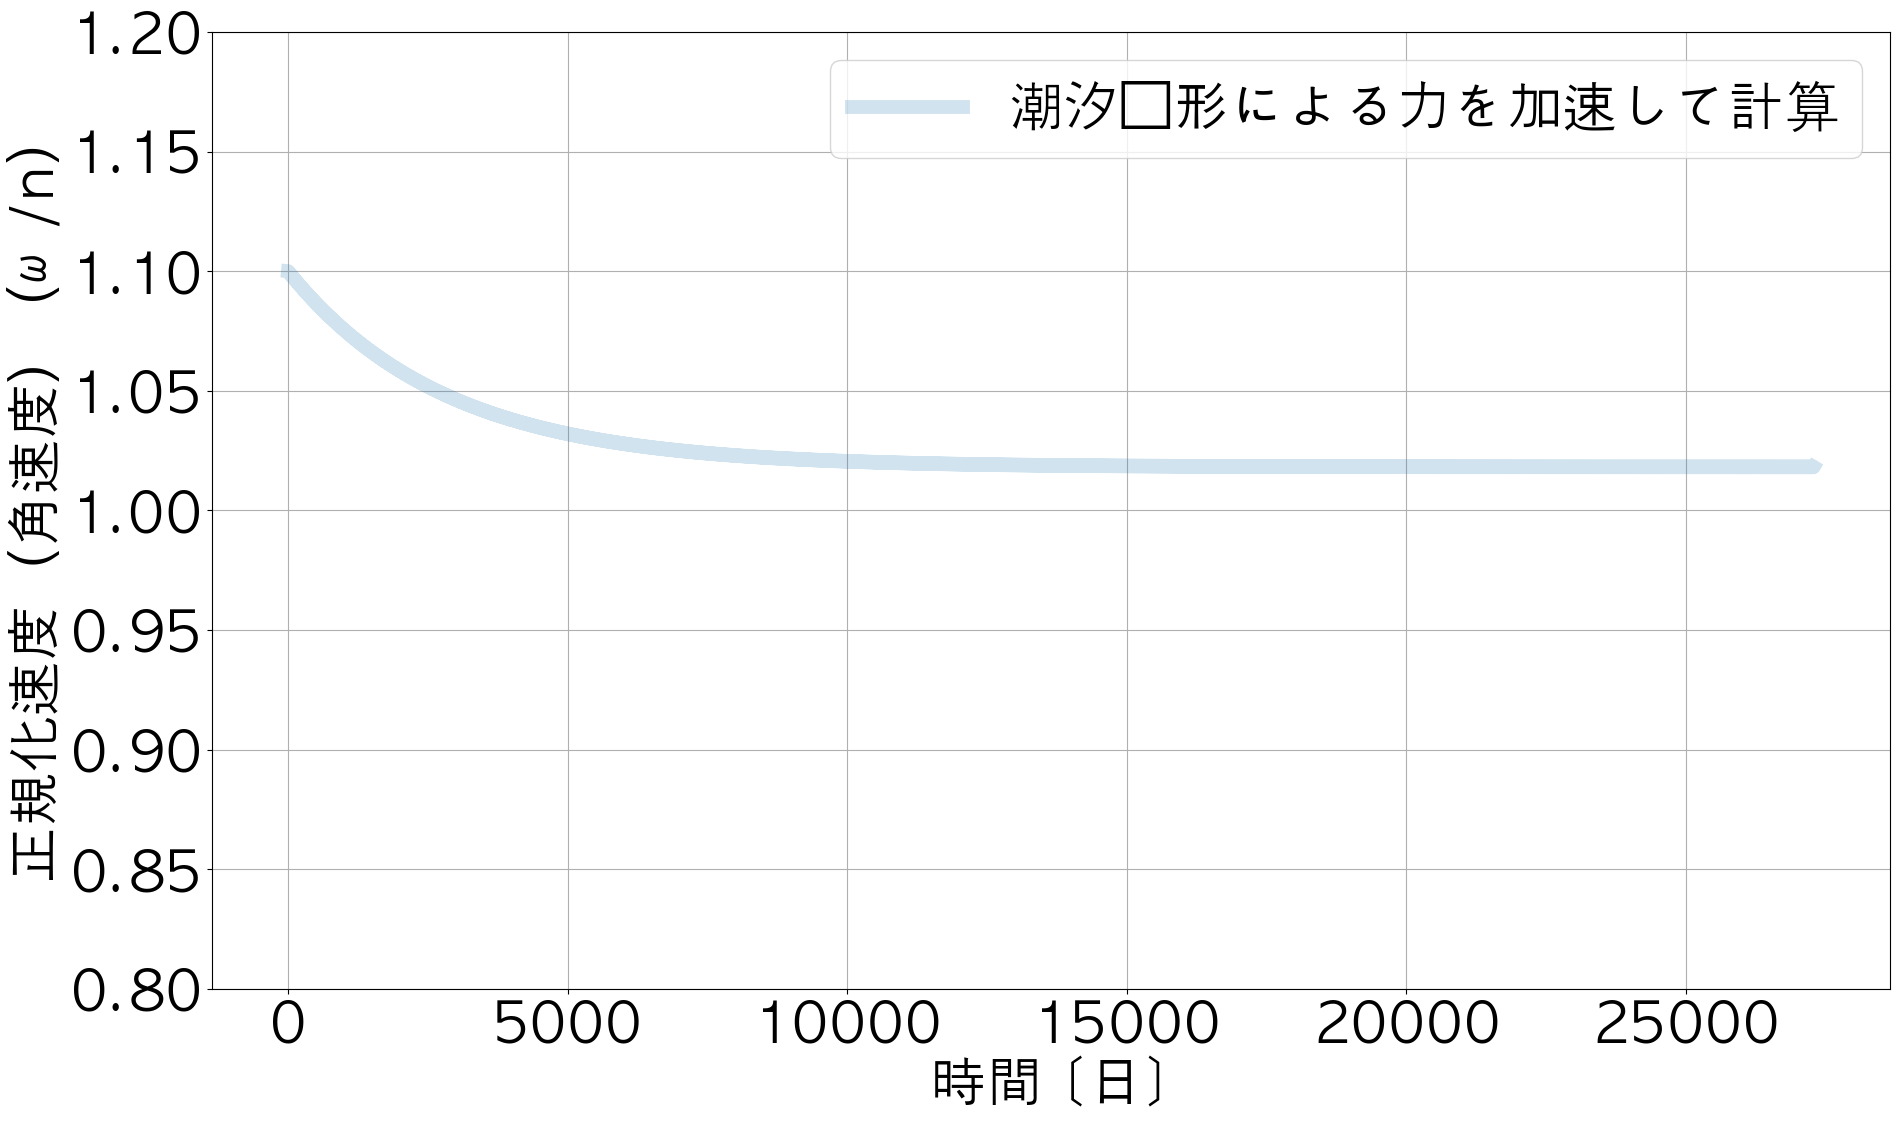

In [46]:
# 楕円軌道＆表裏側の重さが同じ場合
ts, omegas, f_dots, psis = simulation( e = 0.055, omega_init = 1.1, moment_rate = 0,
                                     k2 = 1.0,  dtau=1.0e7, t_total_factor=1000)
results = []
results.append( {"ts":ts, 'omegas':omegas, 'f_dots':f_dots, 'psis':psis, 'label': '潮汐変形による力を加速して計算'} )
plot_results(results)

/var/folders/mn/nmxx09wj21j7f81mwghvt1sw0000gn/T/ipykernel_10633/3681745720.py:286: UserWarning: Glyph 22793 (\N{CJK UNIFIED IDEOGRAPH-5909}) missing from font(s) AppleGothic.
  plt.legend(); plt.grid(True); plt.tight_layout(); plt.ylim(0.8, 1.2); plt.show()


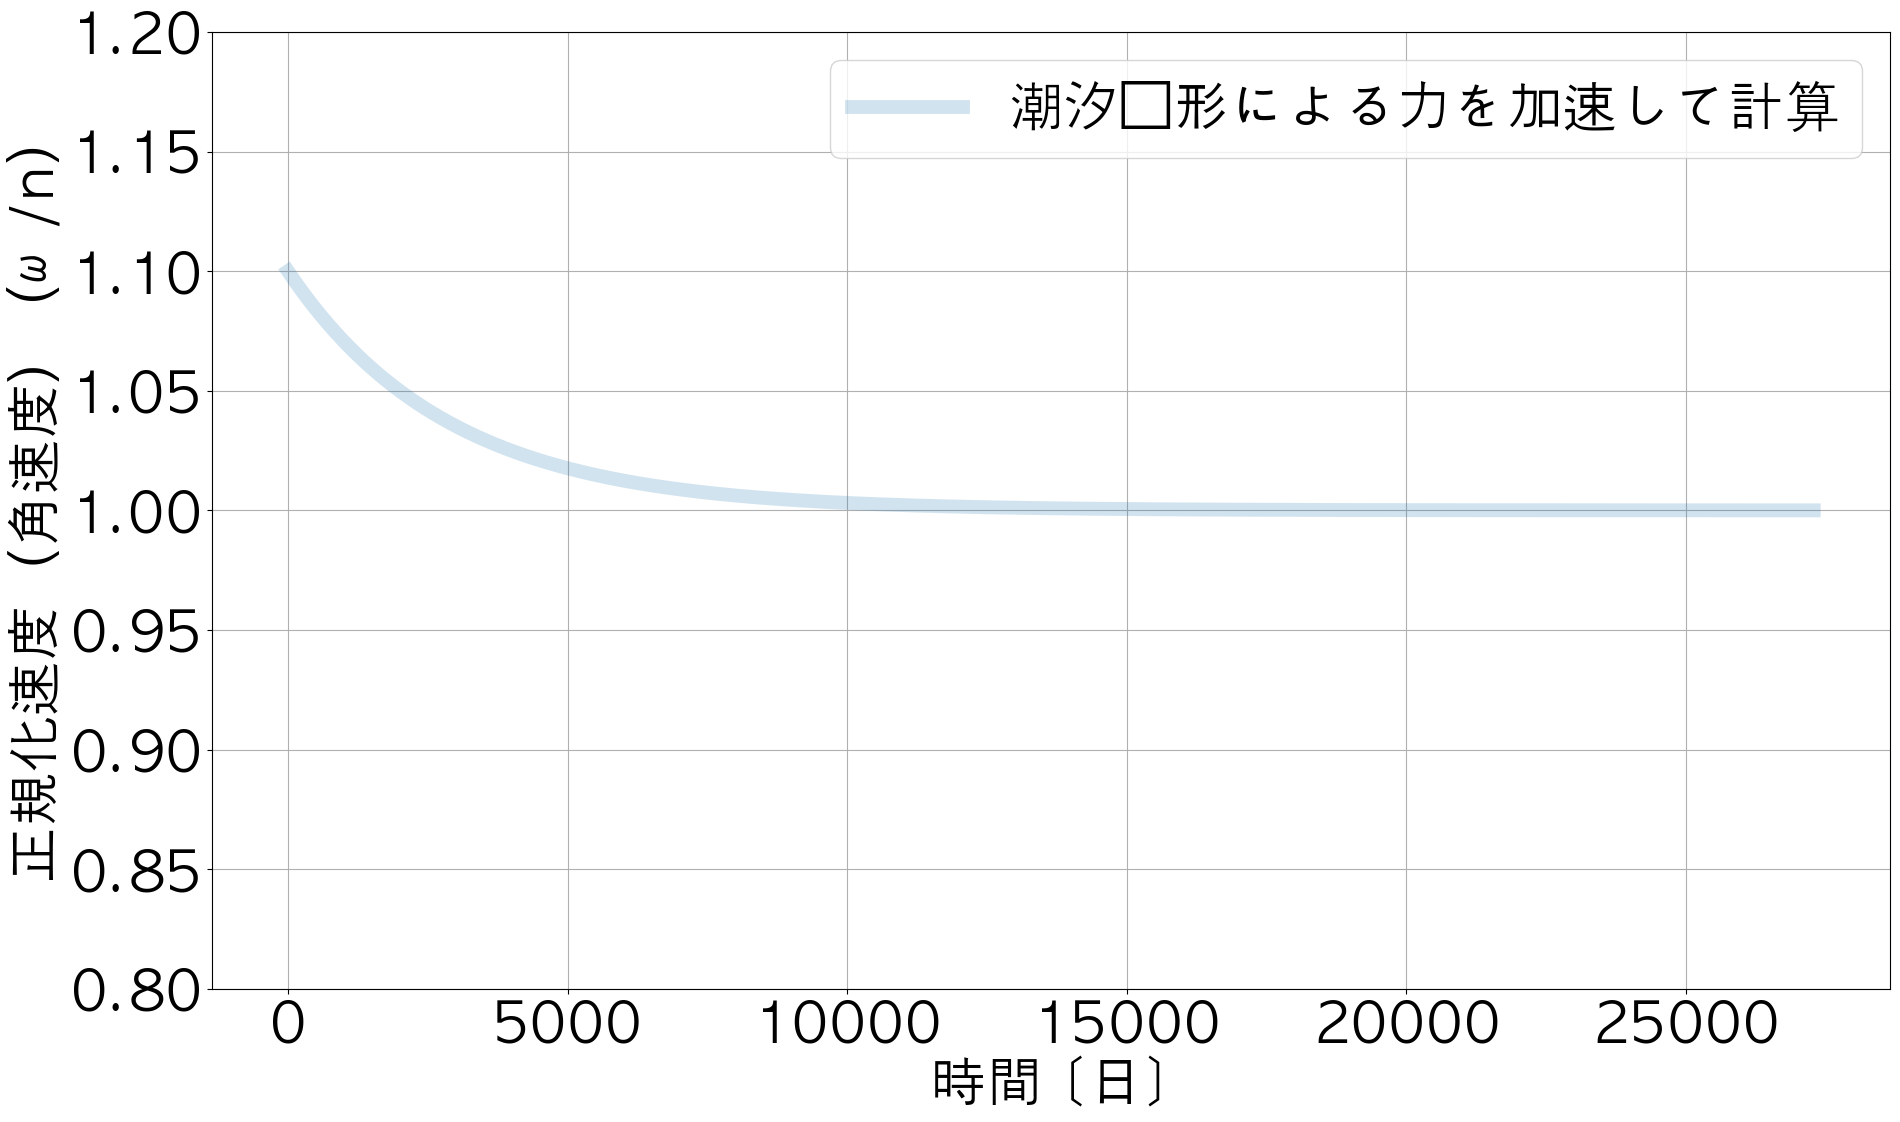

In [47]:
# 楕円軌道＆表裏側の重さが同じ場合
ts, omegas, f_dots, psis = simulation( e = 0.0, omega_init = 1.1, moment_rate = 0,
                                     k2 = 1.0,  dtau=1.0e7, t_total_factor=1000)
results = []
results.append( {"ts":ts, 'omegas':omegas, 'f_dots':f_dots, 'psis':psis, 'label': '潮汐変形による力を加速して計算'} )
plot_results(results)

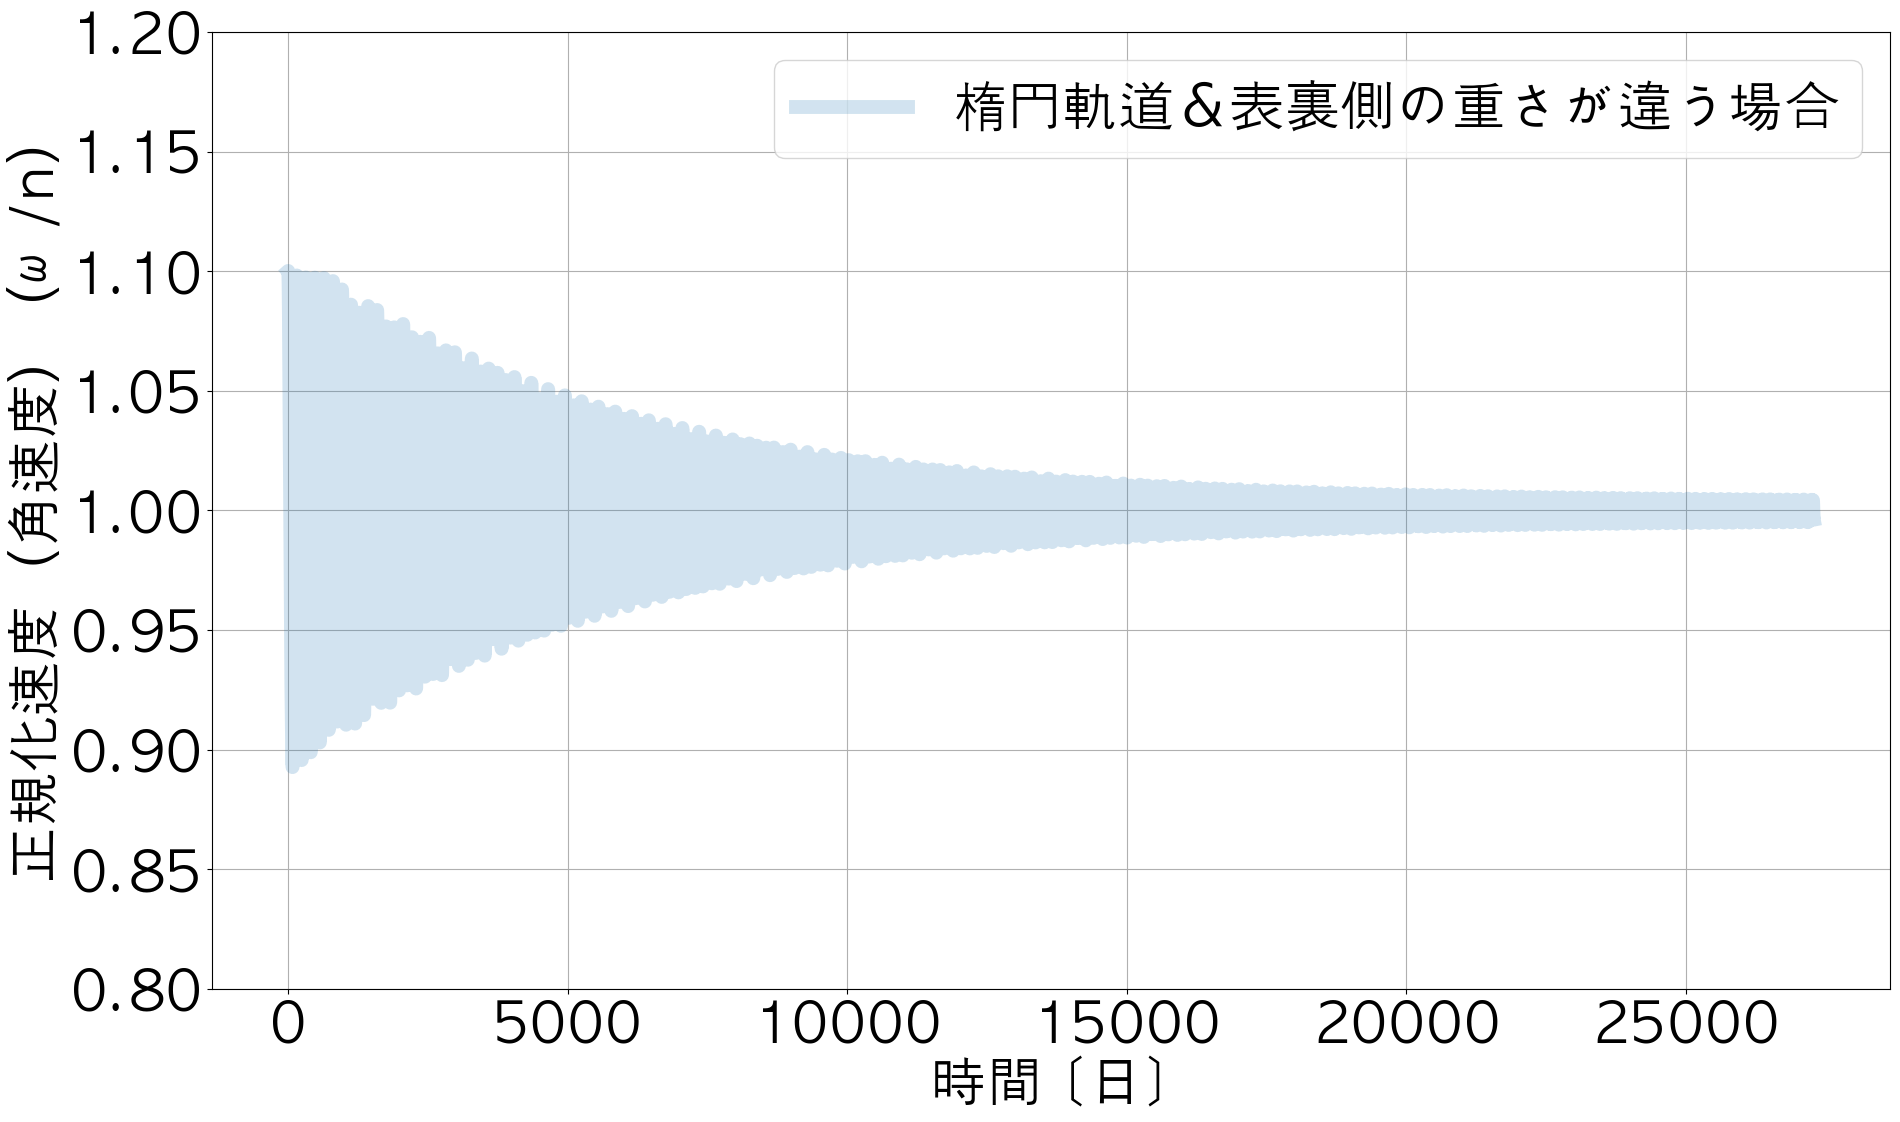

In [48]:
# 楕円軌道＆表裏側の重さが違う場合
ts, omegas, f_dots, psis = simulation( e = 0.055, omega_init = 1.1, moment_rate = 50,
                                     k2 = 1.0,  dtau=1.0e7, t_total_factor=1000)
results = []
results.append( {"ts":ts, 'omegas':omegas, 'f_dots':f_dots, 'psis':psis, 'label': '楕円軌道＆表裏側の重さが違う場合'} )
plot_results(results)

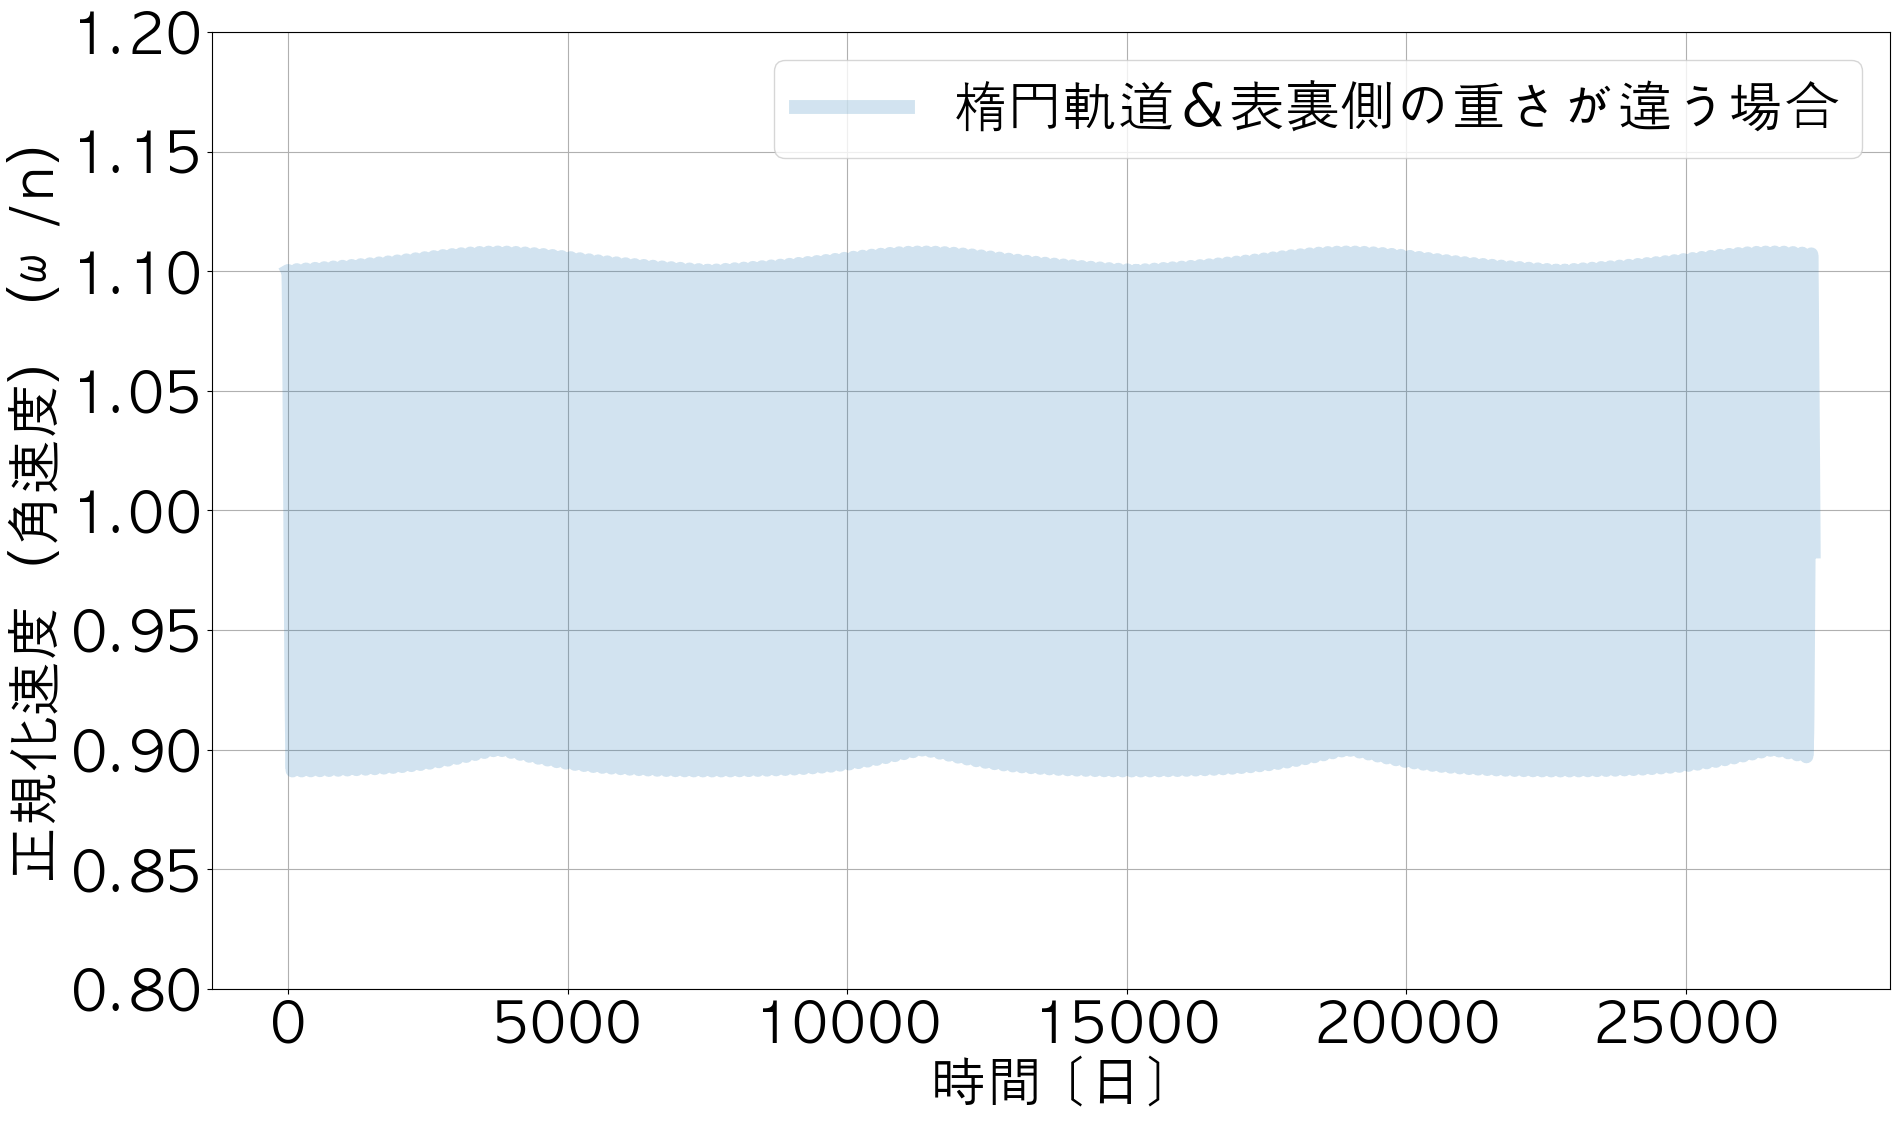

In [49]:
# 楕円軌道＆表裏側の重さが違う場合
ts, omegas, f_dots, psis = simulation( e = 0.055, omega_init = 1.1, moment_rate = 50,
                                     k2 = 1.0,  dtau=0, t_total_factor=1000)
results = []
results.append( {"ts":ts, 'omegas':omegas, 'f_dots':f_dots, 'psis':psis, 'label': '楕円軌道＆表裏側の重さが違う場合'} )
plot_results(results)